In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

# Obtain Stock Info

In [2]:
# Define the instruments to download (https://www.cnbc.com/berkshire-hathaway-portfolio/)
tickers = ['DVA', 'KHC', 'AXP', 'LSXMK', 'LSXMA', 'MCO' ,'BAC' ,'VRSN' ,'AXTA', 'USB', 'LBTYA', 'STOR', 'KO', 'RH', 'BK' ,'GL' ,'AAPL' ,'GM', 'LILA', 'STNE', 'TEVA', 'MTB', 'SYF', 'WFC', 'KR', 'CHTR', 'SNOW', 'LBTYK', 'PNC', 'SU', 'GOLD', 'SIRI', 'COST', 'LILAK', 'JPM', 'V', 'MA', 'BIIB', 'AMZN', 'MDLZ', 'PG', 'JNJ', 'VOO', 'UPS', 'SPY'] # Berkshire Hathaway's holdings

# We would like all available data from 01/01/2010 until 10/10/2020
start_date = '2010-01-01'
end_date = '2020-10-10'


panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)["Adj Close"] #ONLY INTERESTED IN ADJ CLOSE TO CONSIDER STOCK SPLITS

In [3]:
panel_data.tail()

Symbols           DVA        KHC         AXP      LSXMK      LSXMA  \
Date                                                                 
2020-10-05  86.629997  31.000000  103.457878  34.439999  34.349998   
2020-10-06  85.309998  30.670000  101.336746  34.349998  34.580002   
2020-10-07  87.190002  30.840000  102.949997  35.494999  35.610001   
2020-10-08  88.599998  31.219999  106.059998  36.150002  36.180000   
2020-10-09  87.860001  31.110001  106.339996  35.139999  35.330002   

Symbols            MCO        BAC        VRSN       AXTA        USB  ...  \
Date                                                                 ...   
2020-10-05  295.179993  24.620001  203.449997  24.620001  37.730000  ...   
2020-10-06  287.940002  24.370001  202.089996  24.770000  37.419998  ...   
2020-10-07  288.250000  24.879999  203.820007  25.290001  38.790001  ...   
2020-10-08  292.140015  25.240000  205.470001  25.450001  39.500000  ...   
2020-10-09  294.730011  25.360001  209.559998  25.690001  39.169998  ...   

Symbols              V          MA        BIIB         AMZN       MDLZ  \
Date                                                                     
2020-10-05  203.539993  342.850769  284.179993  3199.199951  57.080002   
2020-10-06  200.449997  337.037506  281.149994  3099.959961  56.090000   
2020-10-07  202.470001  343.500000  285.750000  3195.689941  56.189999   
2020-10-08  202.979996  345.149994  286.920013  3190.550049  56.500000   
2020-10-09  206.639999  352.390015  286.540009  3286.649902  57.299999   

Symbols             PG         JNJ         VOO         UPS         SPY  
Date                                                                    
2020-10-05  139.389999  148.229996  312.079987  169.160004  339.760010  
2020-10-06  139.610001  146.259995  307.720001  169.350006  334.929993  
2020-10-07  140.699997  147.880005  313.000000  174.990005  340.760010  
2020-10-08  141.649994  148.889999  315.769989  174.210007  343.779999  
2020-10-09  142.919998  150.970001  318.579987  174.690002  346.850006  

[5 rows x 45 columns]

### Side Project to Predict AAPL stock prices
https://www.youtube.com/watch?v=lpU3PGyDKQ4&t=216s&ab_channel=GilbertTanner

In [25]:
df_array = panel_data["AAPL"].values.reshape(-1, 1)
print(df_array.shape)
df_array[:5]

(2712, 1)


array([[6.60480118],
       [6.61621904],
       [6.51098013],
       [6.49894476],
       [6.5421505 ]])

In [26]:
# Traing on 80% of the data and predict 20%
dataset_train = np.array(df_array[:int(df_array.shape[0]*0.8)])
dataset_test = np.array(df_array[int(df_array.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(2169, 1)
(593, 1)


In [27]:
# scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

# fit and transfrom our data
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.01499341],
       [0.01524601],
       [0.01291781],
       [0.01265155],
       [0.01360739]])

In [28]:
# transform our data with the prefit scaler (it gone up because AAPL stock has risen)
dataset_test = scaler.transform(dataset_test)
dataset_test[:5]

array([[0.90770004],
       [0.91130056],
       [0.90850624],
       [0.8990482 ],
       [0.89652242]])

In [29]:
# function to create datasets
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0]) # only append last 50 prices
        y.append(df[i, 0]) # append next price
    x = np.array(x)
    y = np.array(y)
    return x,y

In [30]:
# training datasets
x_train, y_train = create_dataset(dataset_train)
x_train[:1]

array([[1.49934095e-02, 1.52460068e-02, 1.29178083e-02, 1.26515500e-02,
        1.36073897e-02, 1.23306476e-02, 1.06988453e-02, 1.26993267e-02,
        1.18663308e-02, 9.47670516e-03, 1.56966626e-02, 1.34367060e-02,
        1.09378026e-02, 3.89169564e-03, 7.52397936e-03, 9.48349876e-03,
        1.08080914e-02, 4.94314147e-03, 6.77249602e-06, 1.82974487e-03,
        2.60130306e-03, 4.90219002e-03, 0.00000000e+00, 2.32818792e-03,
        1.41326801e-03, 2.82659932e-03, 2.09600313e-03, 4.51984992e-03,
        5.68732485e-03, 7.74928616e-03, 7.16895077e-03, 7.42837323e-03,
        6.56811855e-03, 5.71468911e-03, 3.42057465e-03, 5.87852655e-03,
        6.79343591e-03, 8.58228208e-03, 1.15659358e-02, 1.14703402e-02,
        1.17980678e-02, 1.27402782e-02, 1.83662497e-02, 1.84550200e-02,
        2.11450512e-02, 2.23877198e-02, 2.28383440e-02, 2.35894054e-02,
        2.17049636e-02, 2.21214405e-02]])

In [31]:
# testing datasets (notice 50 features)
x_test, y_test = create_dataset(dataset_test)
x_test[:1]

array([[0.90770004, 0.91130056, 0.90850624, 0.8990482 , 0.89652242,
        0.90216499, 0.89367426, 0.89421176, 0.88367898, 0.8831414 ,
        0.8667512 , 0.871104  , 0.86551519, 0.8626131 , 0.84783505,
        0.85997997, 0.85852901, 0.86573022, 0.86363417, 0.87475819,
        0.85723941, 0.86519264, 0.87900347, 0.89302942, 0.89179366,
        0.8785199 , 0.89544768, 0.89705975, 0.89480292, 0.89770468,
        0.89206203, 0.90001551, 0.89765117, 0.89856438, 0.9060343 ,
        0.91581471, 0.91253665, 0.89517898, 0.8894289 , 0.89147094,
        0.95171223, 0.9833643 , 0.9865886 , 0.99239244, 0.98185958,
        0.98261211, 0.99137146, 0.98802783, 0.99525402, 1.        ]])

In [32]:
# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Building Model

In [33]:
# initialize the Sequential Model
model = Sequential()
#add an LSTM layer
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# add Dropout Layer
model.add(Dropout(0.2))
# add another LSTM layer and repeat
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96)) #return_sequences = False
model.add(Dropout(0.2))
model.add(Dense(units=1)) #output one value (Dense layer)

In [34]:
model.compile(loss='mean_squared_error', optimizer='adam') #MSE because it is a regression problem and added an optimizer

In [35]:
# check the output and notive how the error decreases with time
if(not os.path.exists('stock_prediction.h5')):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save('stock_prediction.h5')

In [36]:
model = load_model('stock_prediction.h5')

### Visualizing Results

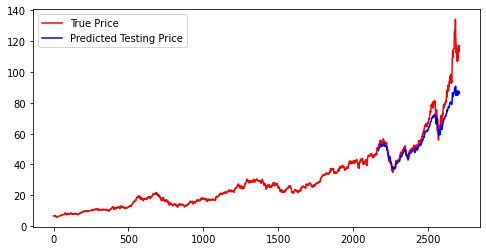

In [37]:
# make predictions on our model testing data
predictions = model.predict(x_test)
#inverse transform it to get initial scale
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df_array, color='red',  label="True Price")
# only plotting our prediction data (shifted by len of training data + 50)
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
plt.legend()

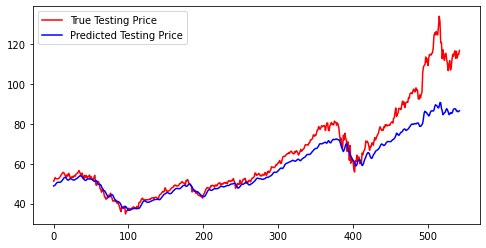

In [39]:
# inverse transform training data
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()

In [40]:
# potential algo to predict future stock prices and feed in the Q-function later on
x = x_test[-1]
num_timesteps = 100
preds = []
for i in range(num_timesteps):
    data = np.expand_dims(x, axis=0)
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    preds.append(prediction[0][0])
    x = np.delete(x, 0, axis=0) # delete first row
    x = np.vstack([x, prediction]) # add prediction

print(preds)

[86.64198, 114.33924, 107.29315, 109.58757, 108.639656, 108.885826, 108.7125, 108.715515, 108.67126, 108.65696, 108.64061, 108.631165, 108.62361, 108.618515, 108.61471, 108.61206, 108.610085, 108.60867, 108.60768, 108.60691, 108.60634, 108.60594, 108.60561, 108.60522, 108.60472, 108.60425, 108.60381, 108.603355, 108.602844, 108.60222, 108.60152, 108.60073, 108.59973, 108.59862, 108.59736, 108.5959, 108.59414, 108.59172, 108.58853, 108.58473, 108.57975, 108.573135, 108.56439, 108.55246, 108.53417, 108.505226, 108.46457, 108.41526, 108.373726, 108.35615, 108.45644, 108.464035, 108.46343, 108.46304, 108.462715, 108.46243, 108.462204, 108.46207, 108.46194, 108.461784, 108.46168, 108.4616, 108.46154, 108.46141, 108.46136, 108.46126, 108.461174, 108.46107, 108.46095, 108.46087, 108.46076, 108.46066, 108.460556, 108.46042, 108.46031, 108.46018, 108.46006, 108.45992, 108.4598, 108.45964, 108.4595, 108.45933, 108.45919, 108.459045, 108.458885, 108.45873, 108.45857, 108.45841, 108.45828, 108.458

# Q-Learning Build Up

In [4]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import numpy as np
import pandas as pd

import random
from collections import deque
import matplotlib.pylab as plt

In [5]:
# taken from the github repo we worked on at the beginning: https://github.com/Rachnog/Deep-Portfolio-Management

class Agent:
    
    def __init__(
                     self, 
                     portfolio_size,
                     is_eval = False, 
                     allow_short = True,
                 ):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell
        
        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.75 # learning slower due to the high density of data (10 years) (we might try high learning rate with fast decay we'll see)
        self.alpha_min = 0.2
        self.alpha_decay = 0.9 # gradual decay of alpha (learn less and less with time)
        self.gamma = 0.95 # future rewards are almost the same worth as immediate rewards (learning does not work well with high gamma values)
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95 # gradual decay with more and more episodes
        
        self.model = self._model()

    def _model(self):
        
        inputs = Input(shape=self.input_shape)        
        x = Flatten()(inputs)
        x = Dense(200, activation='softmax')(x) #changed ELU to softmax to integrate DSRQN
        x = Dropout(0.5)(x)
        x = Dense(100, activation='softmax')(x) # this is exponential normalization
        x = Dropout(0.5)(x)
        x = Dense(50, activation='softmax')(x) # added a third layer
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x) # must be linear because these are the weights   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse') # we use adam and mse because we are dealing with a linear distribution
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else: #sell or short
                weights[e] = -np.abs(pred[e][0][r])

        if not allow_short: #if not shortable
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
            
        weights /= saved_sum
        return weights, saved_min, saved_sum
    
    def act(self, state):
        
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  #generate random weights that follow a normal distribution
              
            saved_min = None
            
            if not self.allow_short: # if not shortable
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size): # Q-Function algorithm

        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size))           
            for i in range(self.portfolio_size):
                if action_weights[i] == 0: #sit
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0: #buy
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else: #short or sell
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        def restore_Q_from_weights_and_stats(action):            
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) #obtain weights
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward) #feed Q-Function weights and update reward
            s, s_ = s.values, s_.values    

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)] #Q-Function update by params set above
            
            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)  
            
        if self.alpha > self.alpha_min: # made alpha dynamic as well
            self.alpha *= self.alpha_decay
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
def get_state(t, lookback, is_cov_matrix = True, is_raw_time_series = False): #might change cov_matrix to something else
    
    def preprocess_state(state):
        return state

    assert lookback <= t

    decision_making_state = panel_data.iloc[t-lookback:t] #create df dataset of required timeframe
    decision_making_state = np.log(decision_making_state).fillna(0) # added np.log to obtain returns and removed pct_change()

    if is_cov_matrix:
        x = decision_making_state.cov()
        return x
    else:
        if is_raw_time_series:
            decision_making_state = panel_data.iloc[t-lookback:t]
        return preprocess_state(decision_making_state)

### Set Reward to Sharpe Ratio

In [6]:
def get_reward(action, action_t, reward_t, alpha = 0.01):

    def local_portfolio(returns, weights):
        average_returns = []
        for i in range(len(data_period.columns)):
            temp_return = np.log(data_period.T.values[i]).mean()
            average_returns.append(temp_return)


        weights = np.array(weights)
#         rets = returns.mean() # * 252
        covs = returns.cov() # * 252
#         P_ret = np.sum(rets * weights)
        P_ret = np.sum(np.array(pd.DataFrame(average_returns).fillna(0)).reshape((len(data_period.columns),)) * weights) #more accurate calculation of Portfolio Returns
        P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
#         P_sharpe = P_ret / P_vol
        P_sharpe = np.array(average_returns) / P_vol #obtain each stock SR based on Portfolio Volatility
        return np.array([P_ret, P_vol, P_sharpe])
    

    data_period = panel_data[action_t:reward_t]
    weights = action

    returns = np.log(data_period).fillna(0)
    sharpe = local_portfolio(returns, weights)[-1]
#     sharpe = np.array([sharpe] * len(panel_data.columns)) #
    rew = (data_period.values[-1] - data_period.values[0]) / data_period.values[0]
#     rew = sharpe

    return np.dot(returns, weights), rew #reward is Sharpe Ratio

### Initialize Params

In [7]:
N_ASSETS = len(tickers)
agent = Agent(N_ASSETS, allow_short = False) # long only portfolio

In [8]:
window_size = 360 #large window size due to large time-frame
episode_count = 50
batch_size = 32
rebalance_period = 30 #rebalance every month

### Run the Algo

Episode 0/50 epsilon 0.8145062499999999
REWARD: 0.7940596415220337


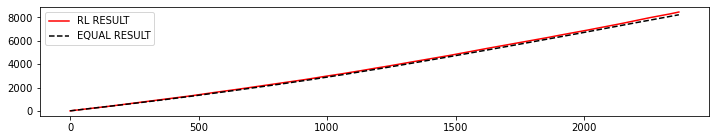

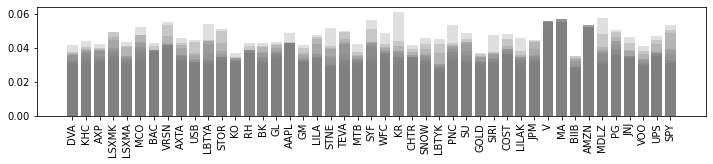

Episode 1/50 epsilon 0.6983372960937497
REWARD: 0.7940596415220337


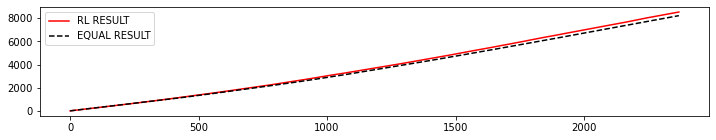

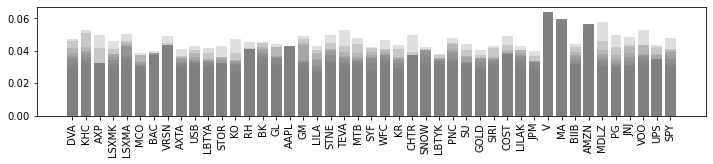

Episode 2/50 epsilon 0.6302494097246091
REWARD: 0.7940596415220337


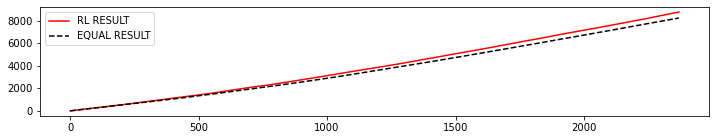

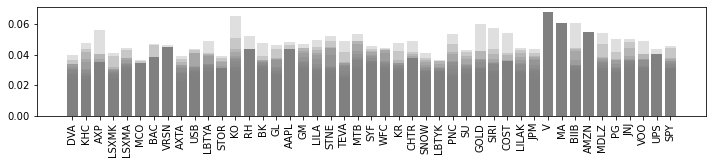

Episode 3/50 epsilon 0.5403600876626365
REWARD: 0.7940596415220337


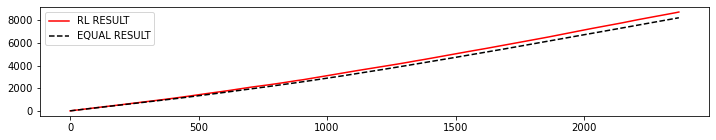

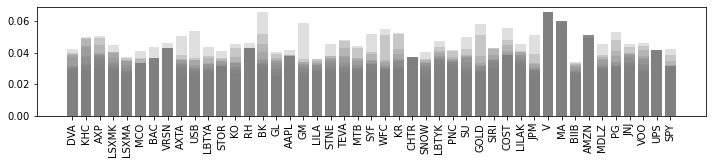

Episode 4/50 epsilon 0.48767497911552943
REWARD: 0.7940596415220337


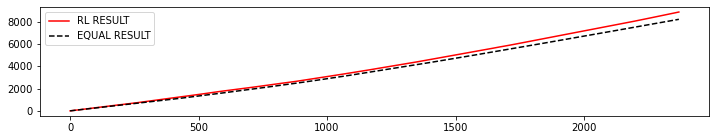

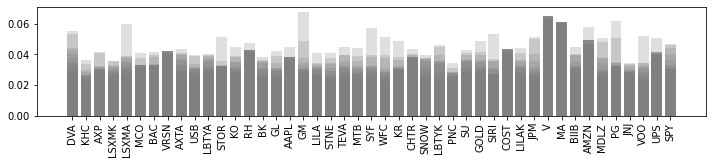

Episode 5/50 epsilon 0.41812033521917696
REWARD: 0.7940596415220337


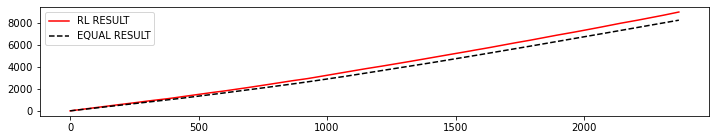

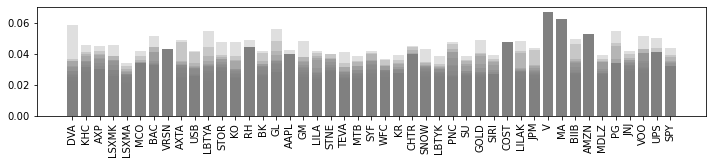

Episode 6/50 epsilon 0.37735360253530714
REWARD: 0.7940596415220337


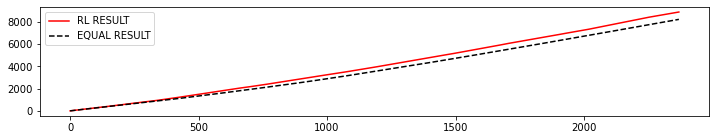

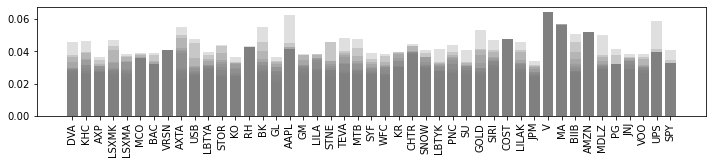

Episode 7/50 epsilon 0.3235335449737089
REWARD: 0.7940596415220337


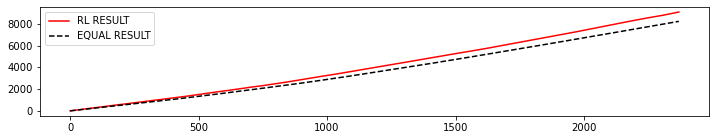

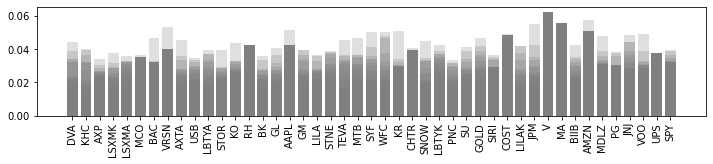

Episode 8/50 epsilon 0.2919890243387723
REWARD: 0.7940596415220337


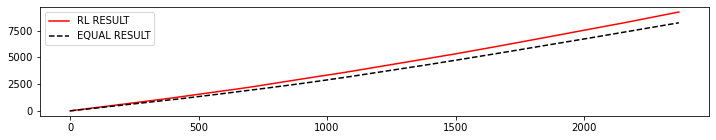

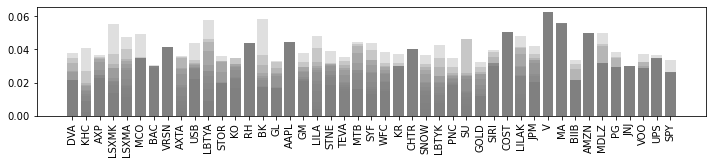

Episode 9/50 epsilon 0.25034408974245487
REWARD: 0.7940596415220337


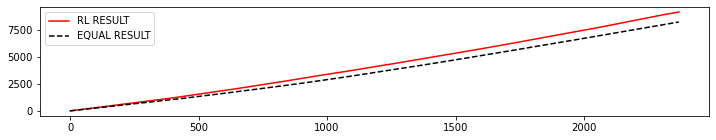

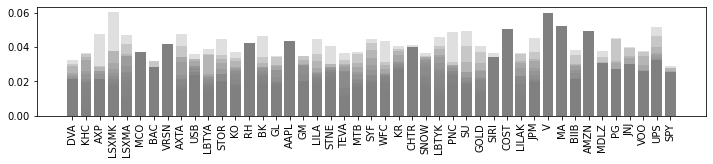

Episode 10/50 epsilon 0.2259355409925655
REWARD: 0.7940596415220337


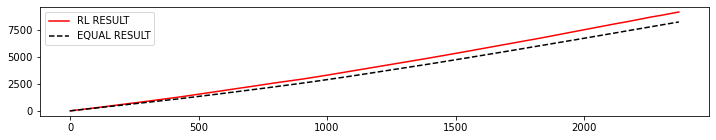

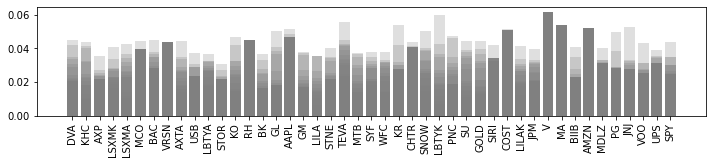

Episode 11/50 epsilon 0.1937114844585008
REWARD: 0.7940596415220337


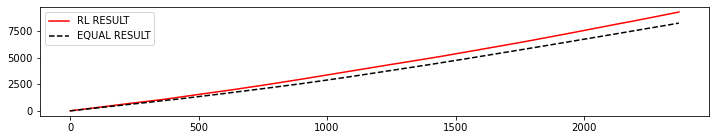

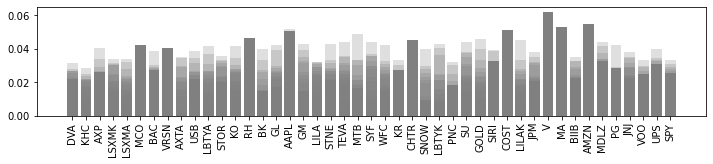

Episode 12/50 epsilon 0.17482461472379698
REWARD: 0.7940596415220337


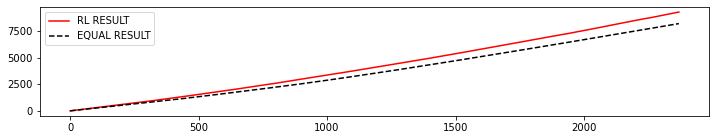

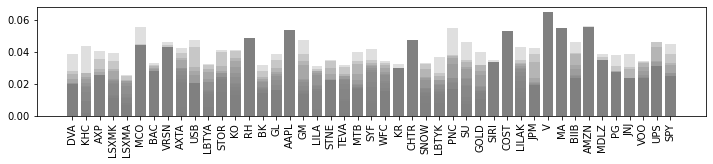

Episode 13/50 epsilon 0.14989025404881542
REWARD: 0.7940596415220337


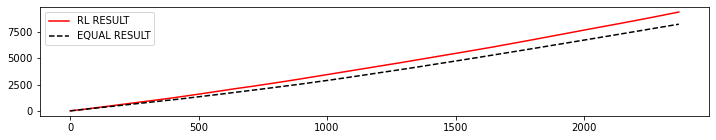

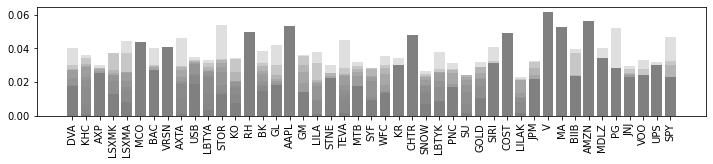

Episode 14/50 epsilon 0.1352759542790559
REWARD: 0.7940596415220337


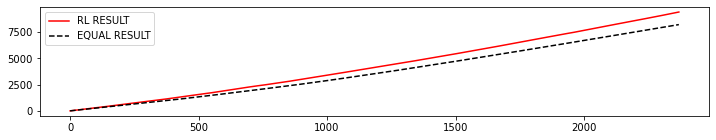

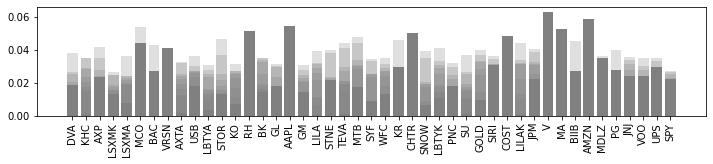

Episode 15/50 epsilon 0.12208654873684793
REWARD: 0.7940596415220337


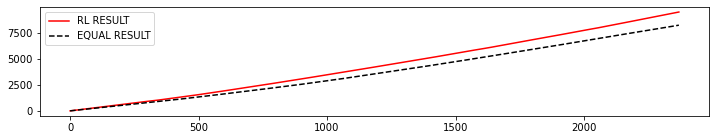

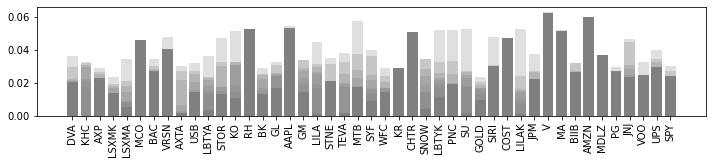

Episode 16/50 epsilon 0.10467395472325498
REWARD: 0.7940596415220337


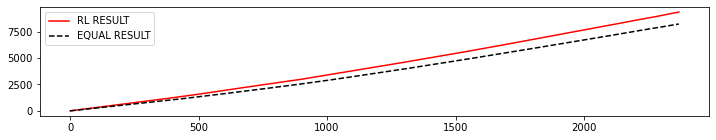

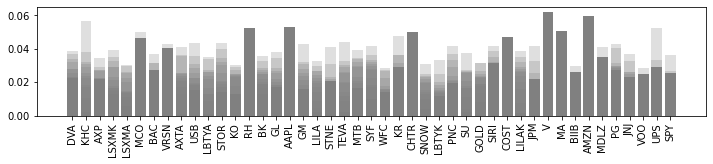

Episode 17/50 epsilon 0.09446824413773762
REWARD: 0.7940596415220337


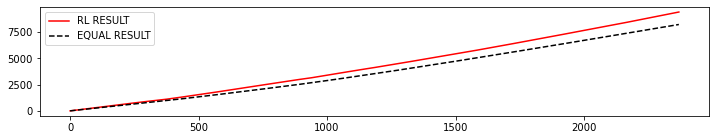

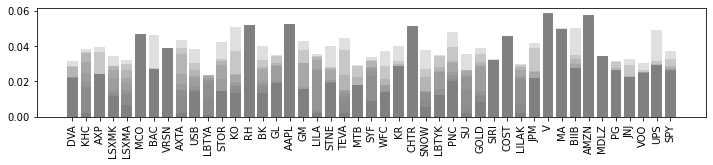

Episode 18/50 epsilon 0.08099471081759278
REWARD: 0.7940596415220337


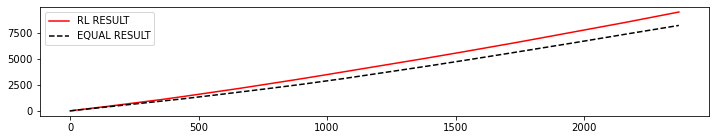

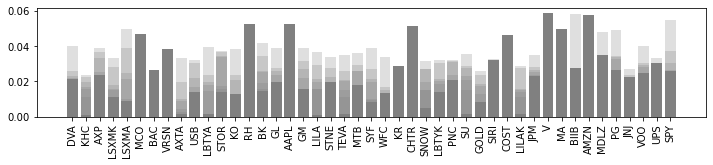

Episode 19/50 epsilon 0.07309772651287748
REWARD: 0.7940596415220337


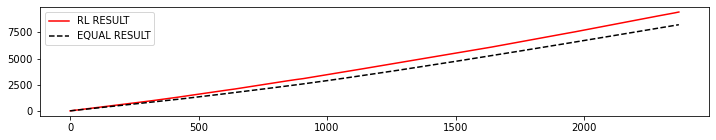

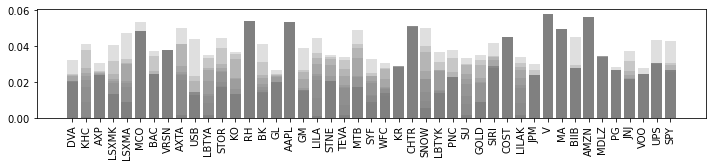

Episode 20/50 epsilon 0.0626721632689783
REWARD: 0.7940596415220337


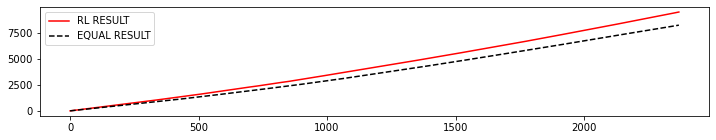

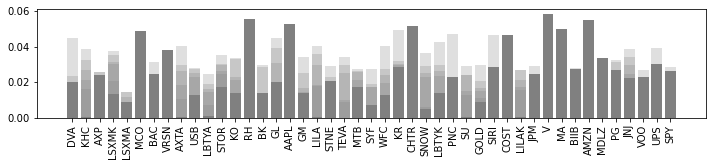

Episode 21/50 epsilon 0.05656162735025291
REWARD: 0.7940596415220337


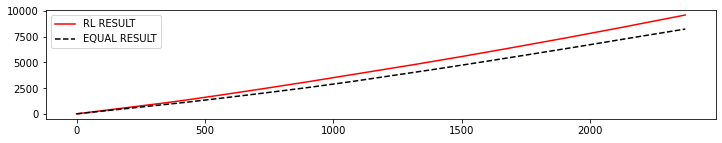

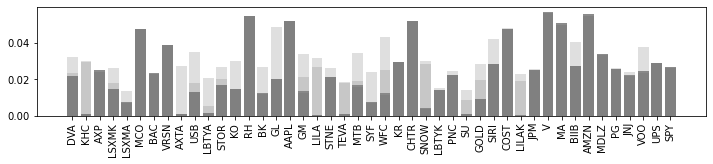

Episode 22/50 epsilon 0.04849452524942309
REWARD: 0.7940596415220337


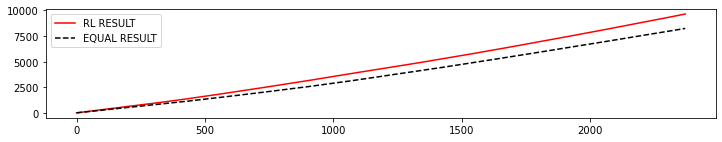

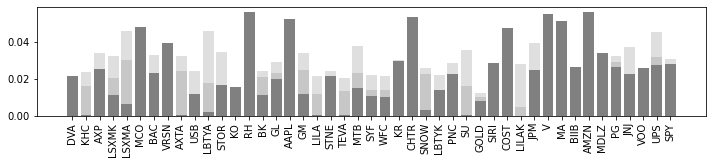

Episode 23/50 epsilon 0.04376630903760433
REWARD: 0.7940596415220337


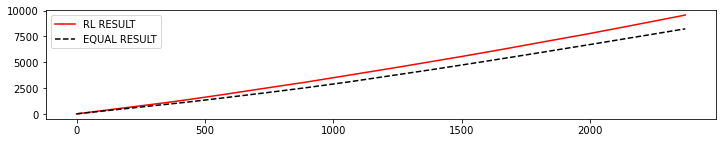

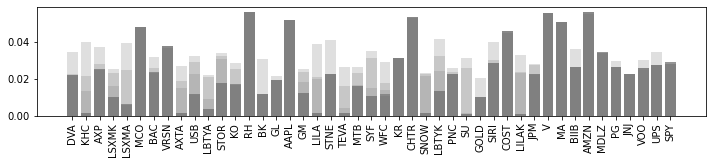

Episode 24/50 epsilon 0.03752413921111601
REWARD: 0.7940596415220337


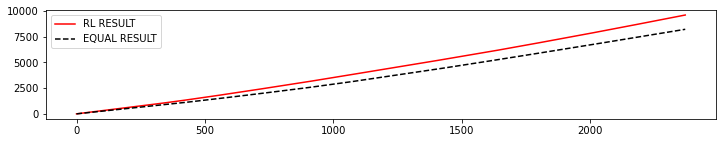

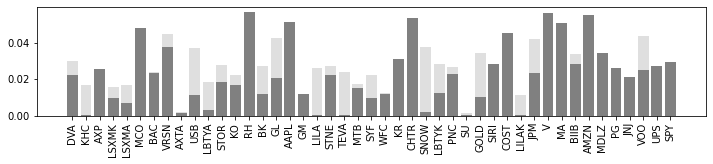

Episode 25/50 epsilon 0.0338655356380322
REWARD: 0.7940596415220337


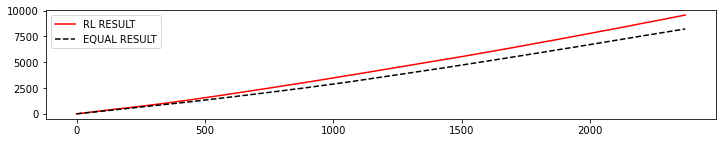

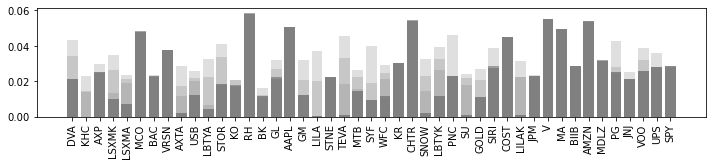

Episode 26/50 epsilon 0.029035463617657853
REWARD: 0.7940596415220337


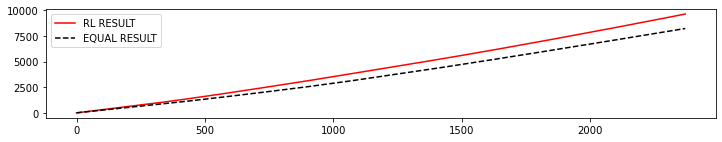

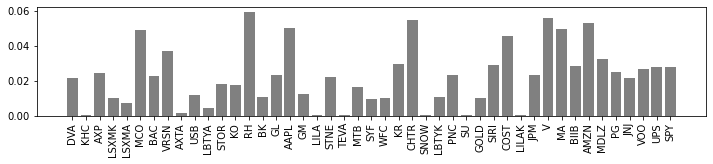

Episode 27/50 epsilon 0.02620450591493621
REWARD: 0.7940596415220337


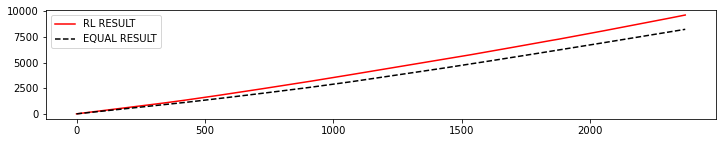

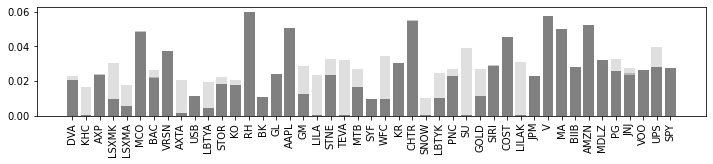

Episode 28/50 epsilon 0.022467088258818428
REWARD: 0.7940596415220337


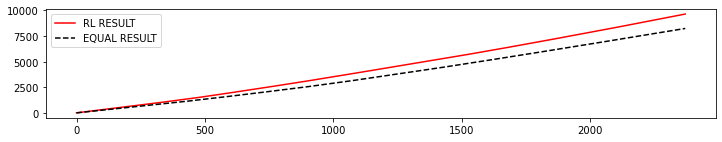

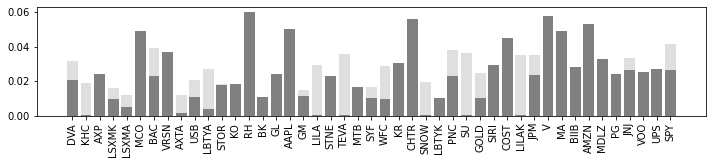

Episode 29/50 epsilon 0.02027654715358363
REWARD: 0.7940596415220337


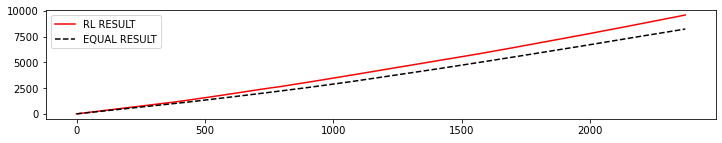

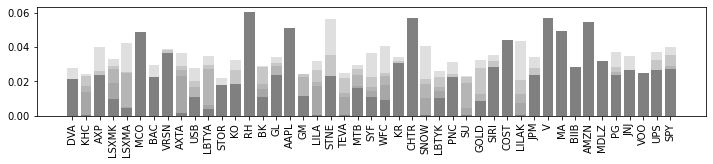

Episode 30/50 epsilon 0.017384604615803764
REWARD: 0.7940596415220337


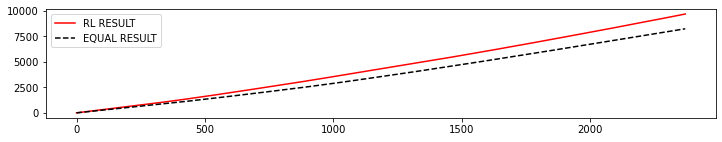

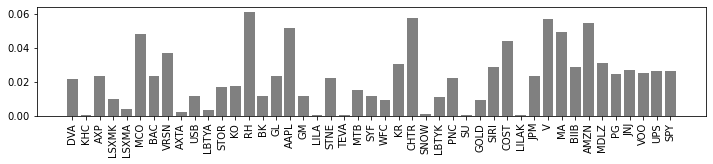

Episode 31/50 epsilon 0.015689605665762895
REWARD: 0.7940596415220337


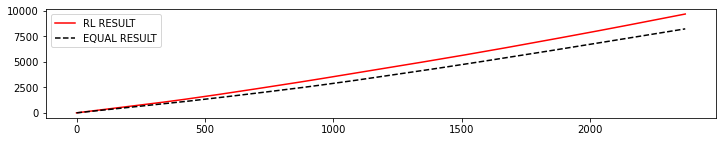

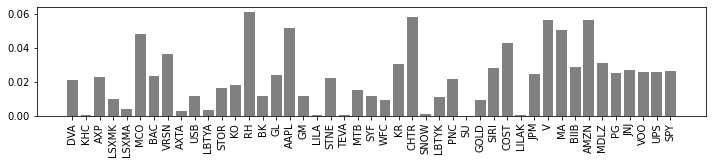

Episode 32/50 epsilon 0.014159869113351011
REWARD: 0.7940596415220337


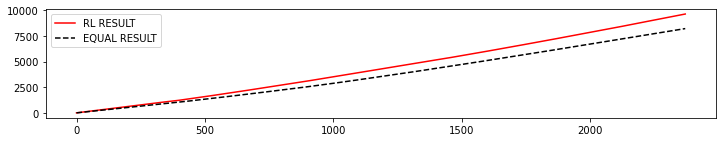

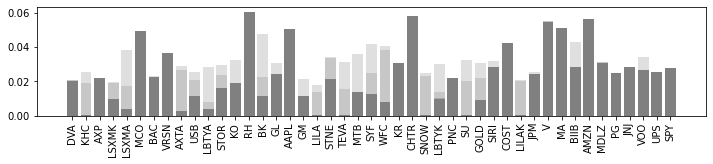

Episode 33/50 epsilon 0.012140317781059323
REWARD: 0.7940596415220337


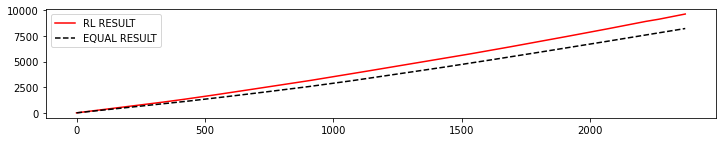

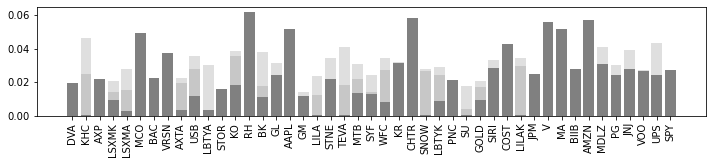

Episode 34/50 epsilon 0.010956636797406038
REWARD: 0.7940596415220337


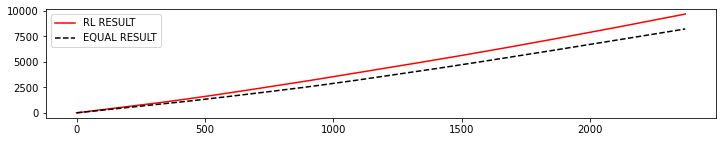

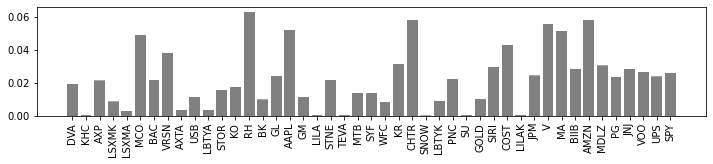

Episode 35/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


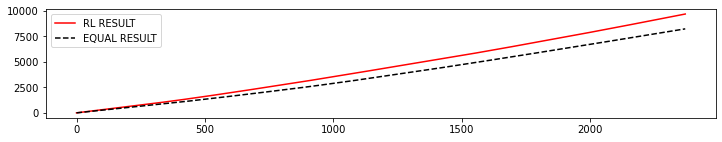

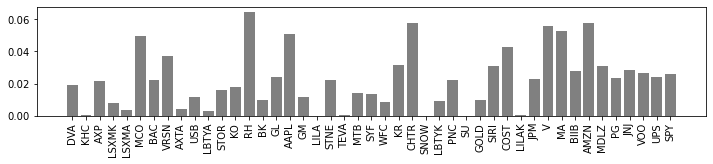

Episode 36/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


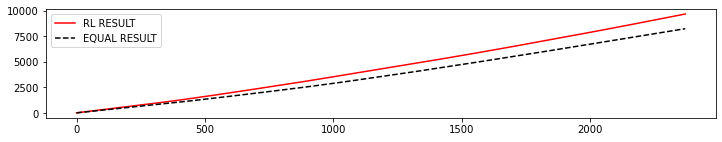

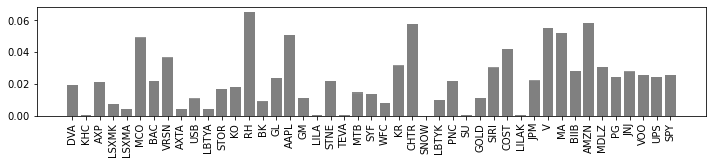

Episode 37/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


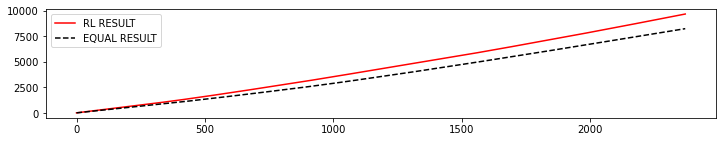

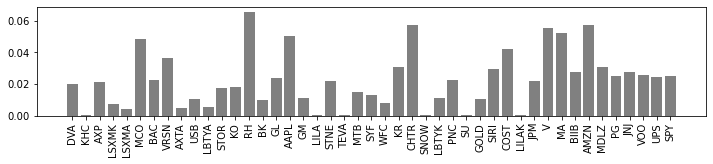

Episode 38/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


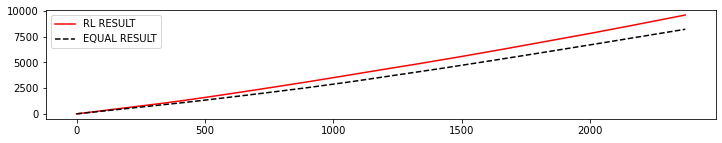

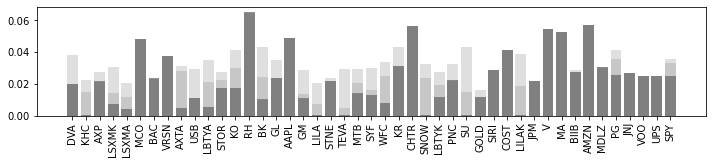

Episode 39/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


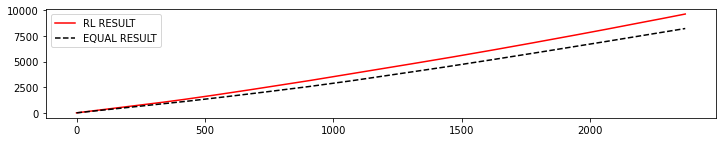

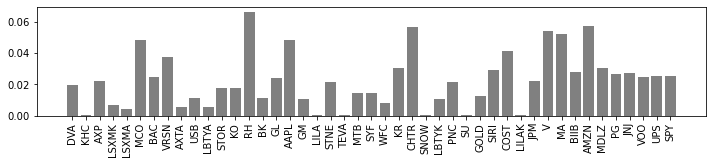

Episode 40/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


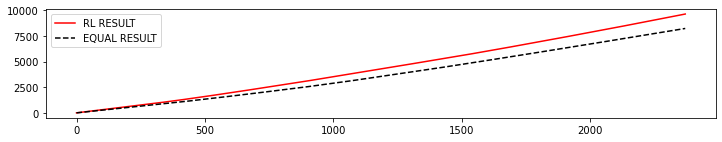

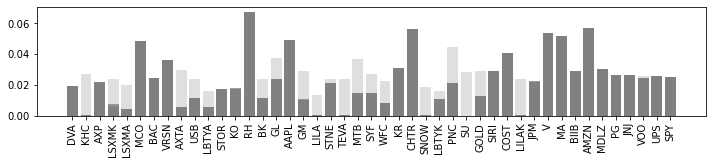

Episode 41/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


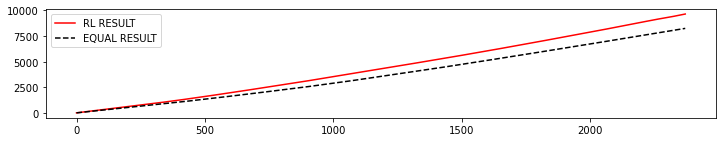

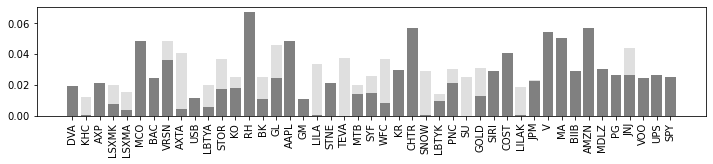

Episode 42/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


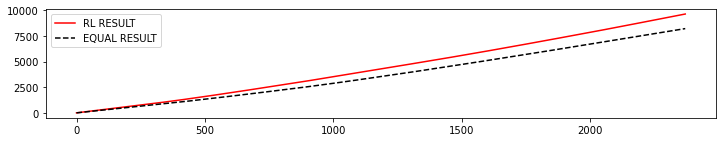

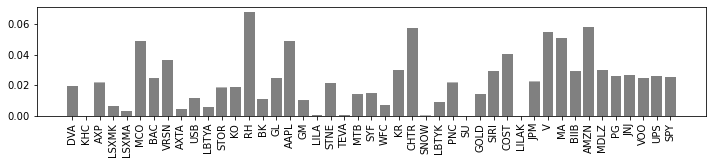

Episode 43/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


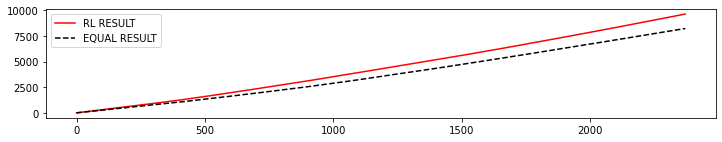

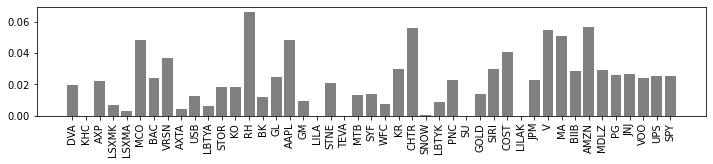

Episode 44/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


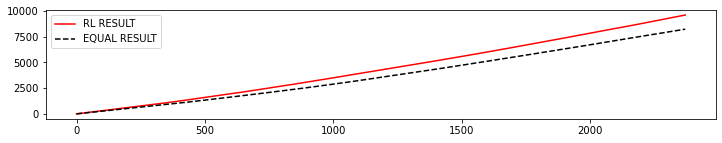

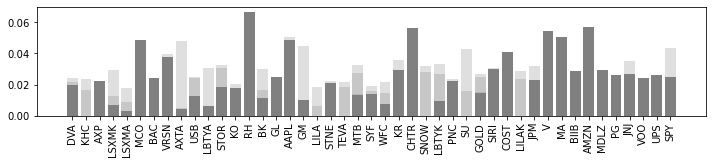

Episode 45/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


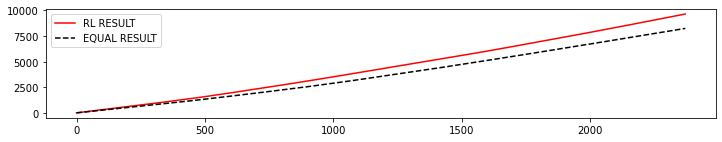

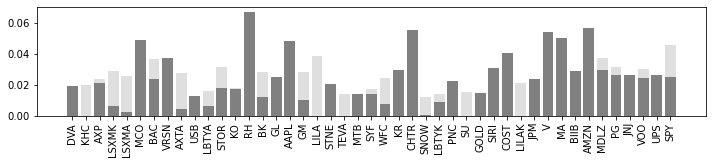

Episode 46/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


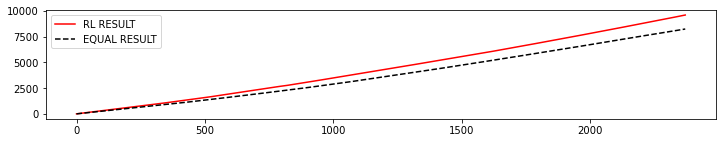

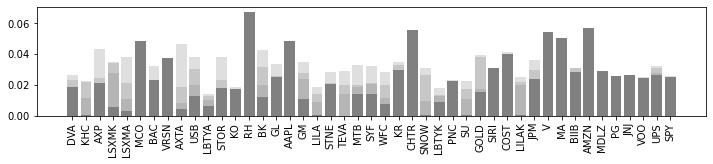

Episode 47/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


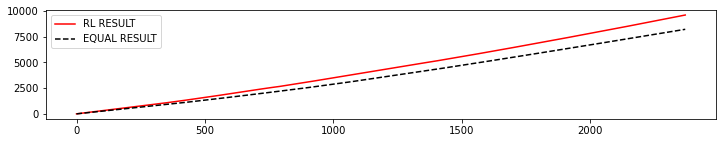

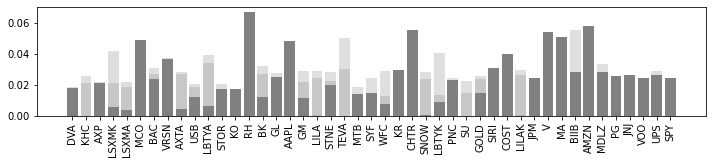

Episode 48/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


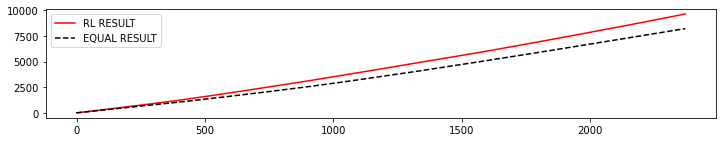

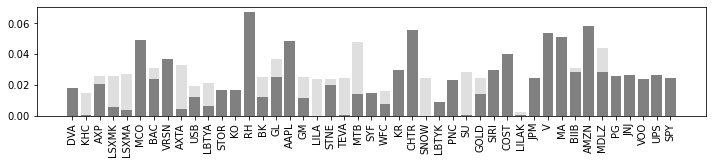

Episode 49/50 epsilon 0.009888364709658948
REWARD: 0.7940596415220337


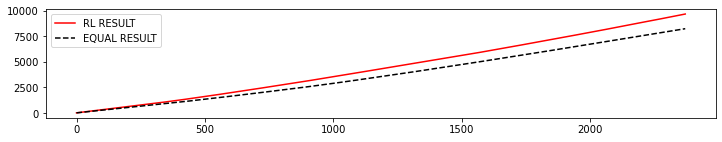

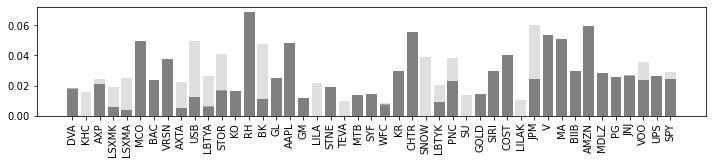

In [15]:
for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(panel_data)
    
    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size) #generate price dataset of given time interval
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):

        date1 = t-rebalance_period
        
        s_ = get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0]) 
    
        temp_reward = get_reward(action[0], date1, t) 
        weighted_returns = np.nan_to_num(temp_reward[0], 0)
        reward = np.nan_to_num(temp_reward[1], 0)

#         weighted_returns, reward = np.nan_to_num(get_reward(action[0], date1, t), 0) #obtain reward
        weighted_returns_equal, reward_equal = get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
#         print("REWARD: {}".format(reward))
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size) #apply Q-function and update params
            agent.memory4replay = []
            
        s = s_ #update dataset

    print("REWARD: {}".format(np.array(rewards_history).max()))

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'red', ls = '-', label= "RL RESULT")
    plt.plot(equal_result, color = 'black', ls = '--', label = "EQUAL RESULT")
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize = (12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), panel_data.columns, rotation='vertical')
    plt.show()
    

# Evaluating agent

In [11]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(panel_data), rebalance_period):

    date1 = t-rebalance_period
    s_ = get_state(t, window_size) #obtain price dataset of given time interval
    action = agent.act(s_)

    weighted_returns, reward = get_reward(action[0], date1, t) #obtain rewards
    weighted_returns_equal, reward_equal = get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
    
    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])

In [10]:
import statsmodels.api as sm
from statsmodels import regression

def sharpe(R): #Sharpe Ratio Formula and assuming risk free rate = 0
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark): #benchmark will be the equally weighted portfolio (might change it to SPY)

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))

    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()
    alpha = model.params[0]
    beta = model.params[1]

    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

In [12]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]

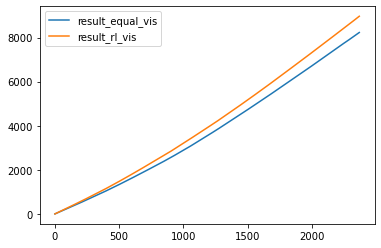

In [13]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'result_equal_vis')
plt.plot(np.array(result_rl_vis).cumsum(), label = 'result_rl_vis')
plt.legend()
plt.show()

In [14]:
EQUAL = print_stats(result_equal_vis, result_equal_vis)
RL_AGENT = print_stats(result_rl_vis, result_equal_vis)

print(f'EQUAL:\nRET: {EQUAL[0]}, VOL: {EQUAL[1]}, SR: {EQUAL[2]}, ALPHA: {EQUAL[3]}, BETA: {EQUAL[4]}') # try weighting against a complete spy portfolio not equally weighted
print(f'RL AGENT:\nRET: {RL_AGENT[0]}, VOL: {RL_AGENT[1]}, SR: {RL_AGENT[2]}, ALPHA: {RL_AGENT[3]}, BETA: {RL_AGENT[4]}') 


EQUAL:
RET: 3.4721, VOL: 0.5489, SR: 100.4598, ALPHA: -0.0, BETA: 1.0
RL AGENT:
RET: 3.7829, VOL: 0.5619, SR: 106.9214, ALPHA: 0.2437, BETA: 1.0193


### Save GIFS/PHOTOS

In [16]:
import matplotlib
def plot_results(benchmark_series,
                 target_series,
                 target_balances,
                 n_assets,
                 columns,
                 name2plot = '',
                 path2save = './',
                 base_name_series = 'series'):

#     N = len(np.array(benchmark_series).cumsum())
    N = len(np.array([item for sublist in benchmark_series for item in sublist]).cumsum())

    if not os.path.exists(path2save):
        os.makedirs(path2save)

    for i in range(0, len(target_balances)):

        current_range = np.arange(0, N)
        current_ts = np.zeros(N)
        current_ts2 = np.zeros(N)

        ts_benchmark = np.array([item for sublist in benchmark_series[:i+1] for item in sublist]).cumsum()
        ts_target = np.array([item for sublist in target_series[:i+1] for item in sublist]).cumsum()

        t = len(ts_benchmark)
        current_ts[:t] = ts_benchmark
        current_ts2[:t] = ts_target

        current_ts[current_ts == 0] = ts_benchmark[-1]
        current_ts2[current_ts2 == 0] = ts_target[-1]

        plt.figure(figsize = (12, 10))

        plt.subplot(2, 1, 1)
        plt.bar(np.arange(n_assets), target_balances[i], color = 'grey')
        plt.xticks(np.arange(n_assets), columns, rotation='vertical')
        plt.ylabel(["Weights"])
        

        plt.subplot(2, 1, 2)
        current_cmap = matplotlib.cm.get_cmap()
        current_cmap.set_bad(color='red')
        plt.colormaps = current_cmap
        plt.plot(current_range[:t], current_ts[:t], color = 'black', label = 'Benchmark')
        plt.plot(current_range[:t], current_ts2[:t], color = 'red', label = name2plot)
        plt.plot(current_range[t:], current_ts[t:], ls = '--', lw = .1, color = 'black')
#         plt.autoscale(False)
#         plt.ylim([-1, 1])
        plt.legend()
        plt.savefig(path2save + base_name_series + str(i) + '.jpg')

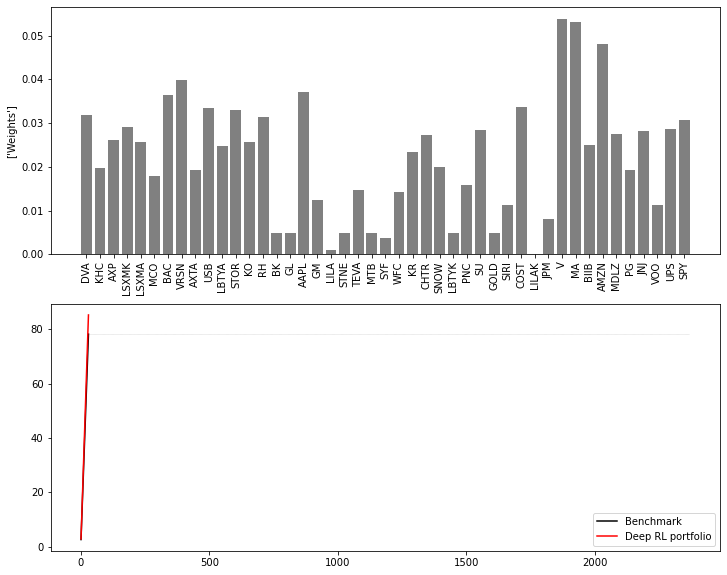

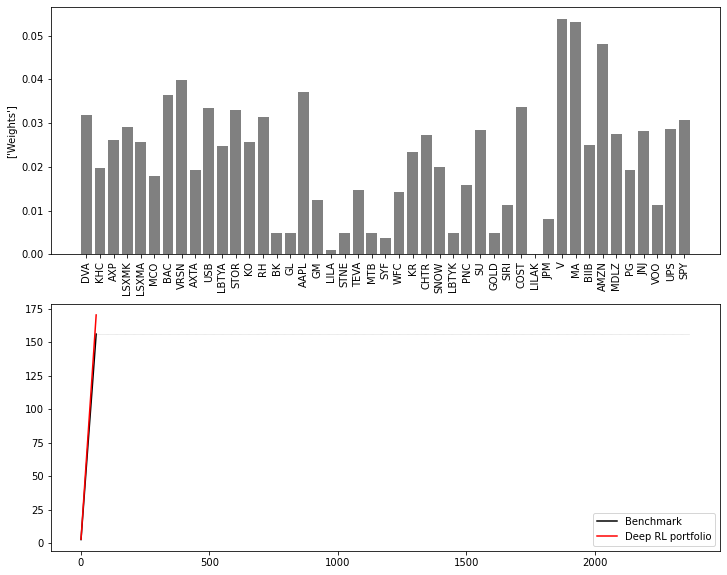

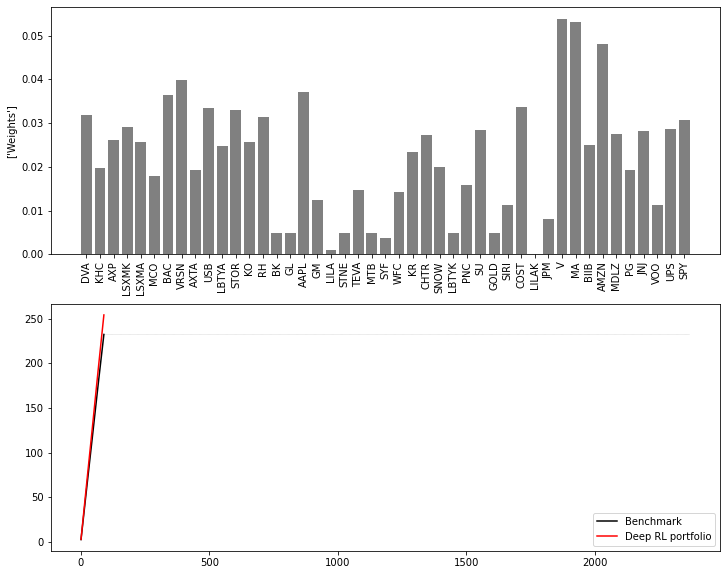

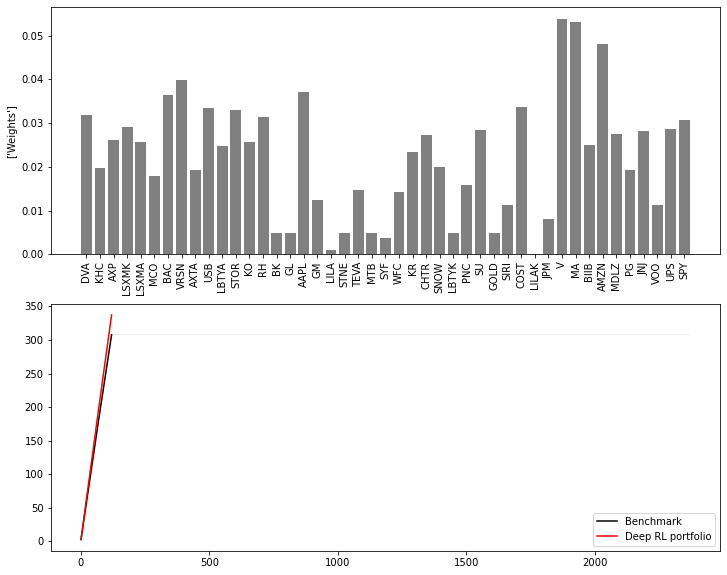

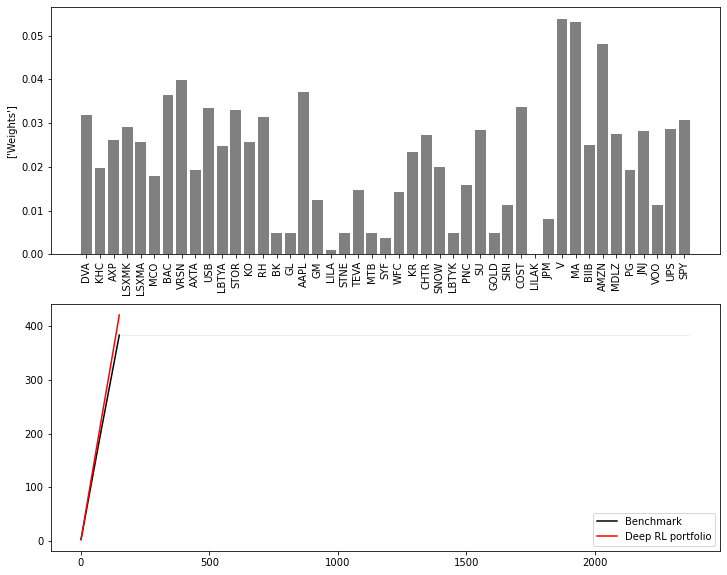

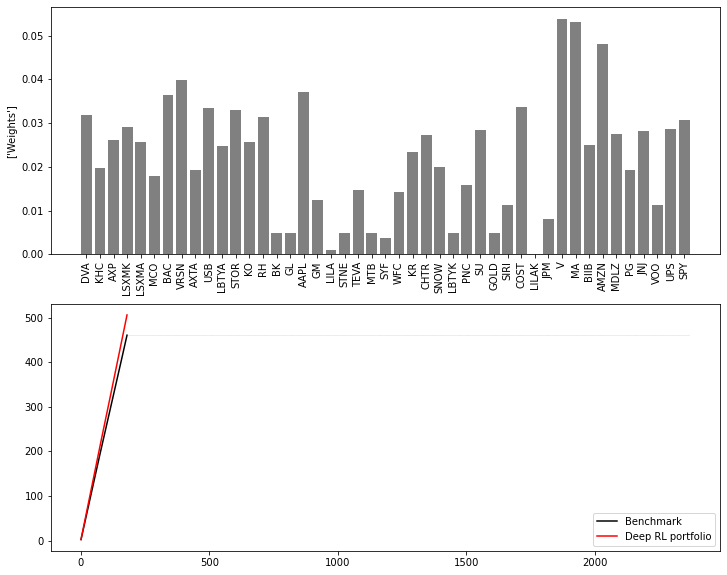

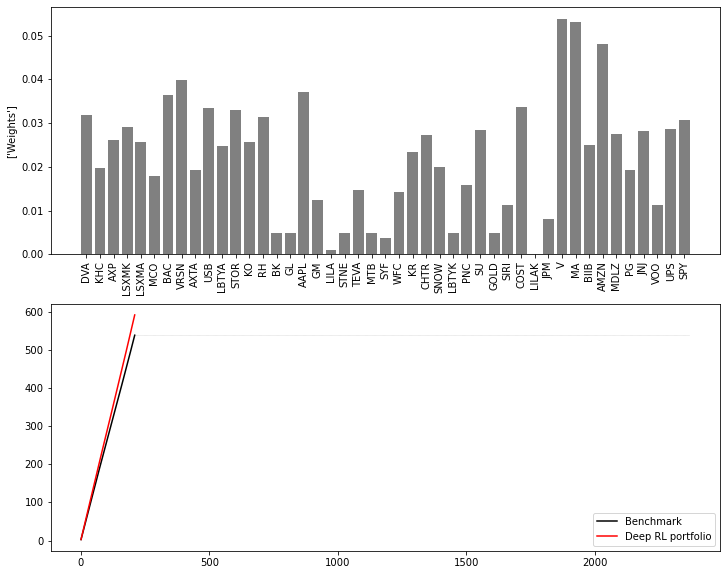

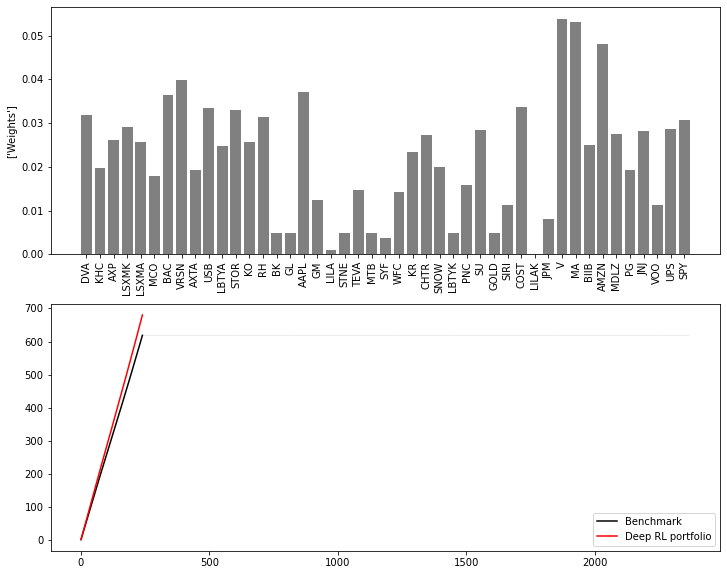

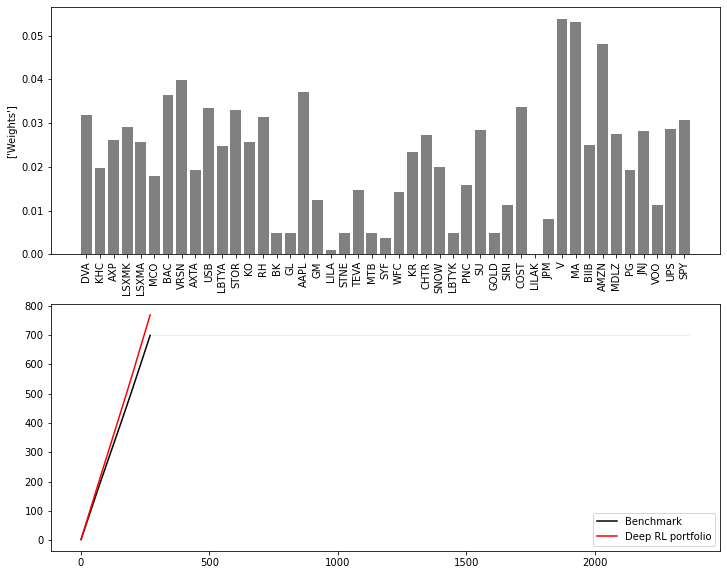

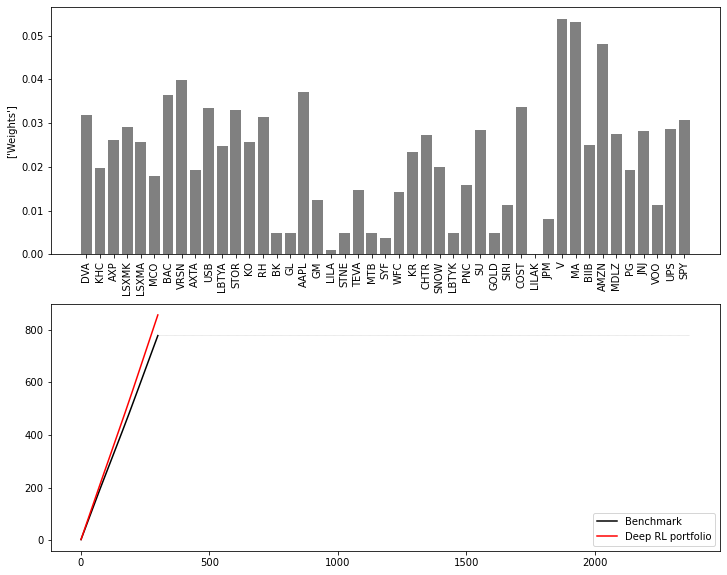

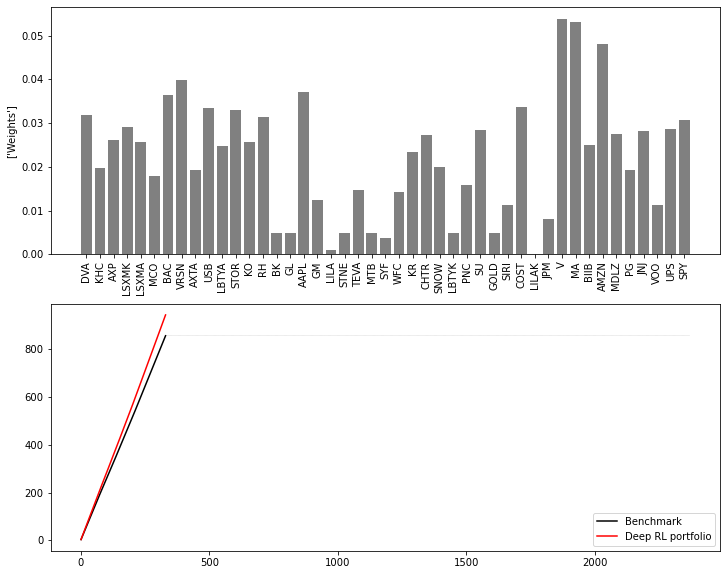

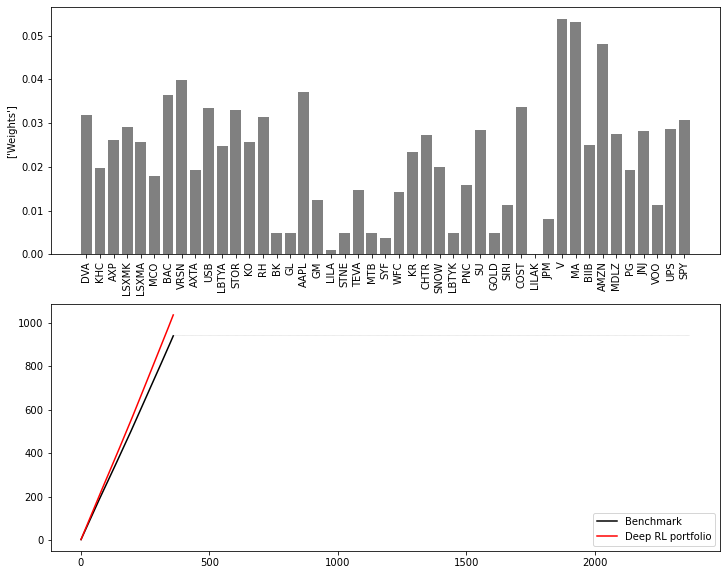

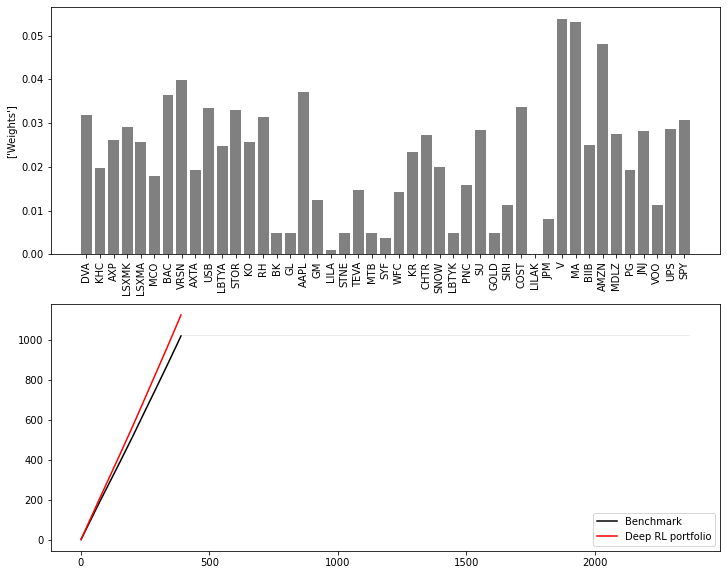

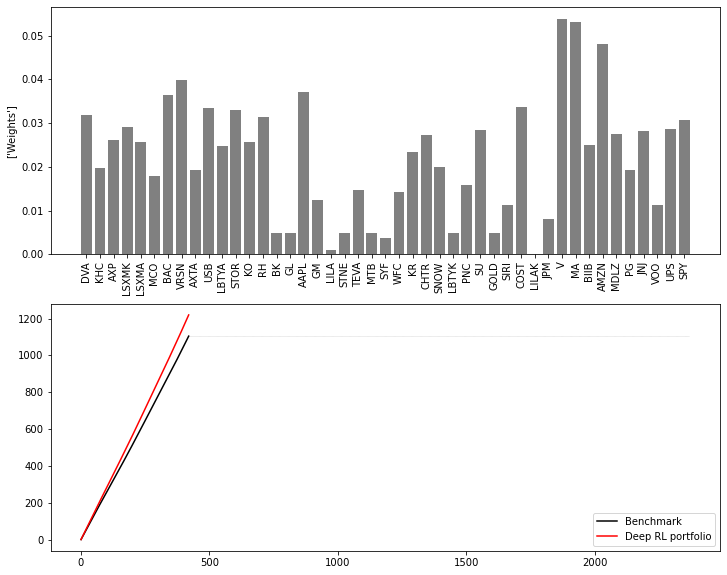

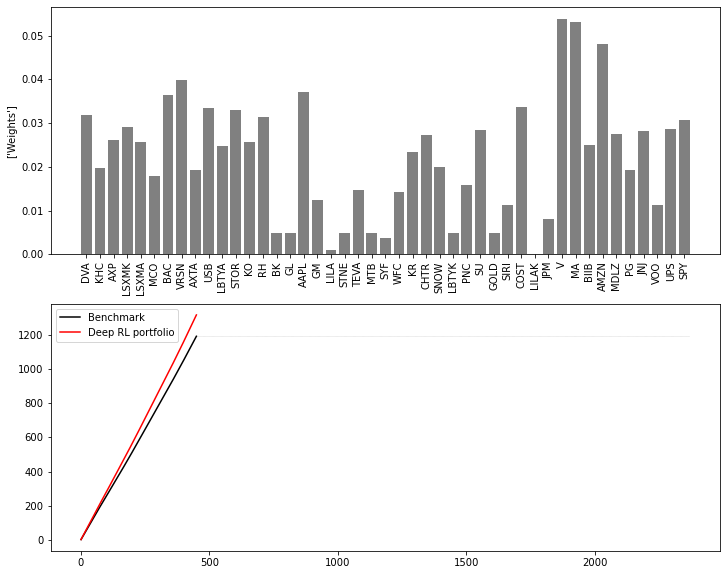

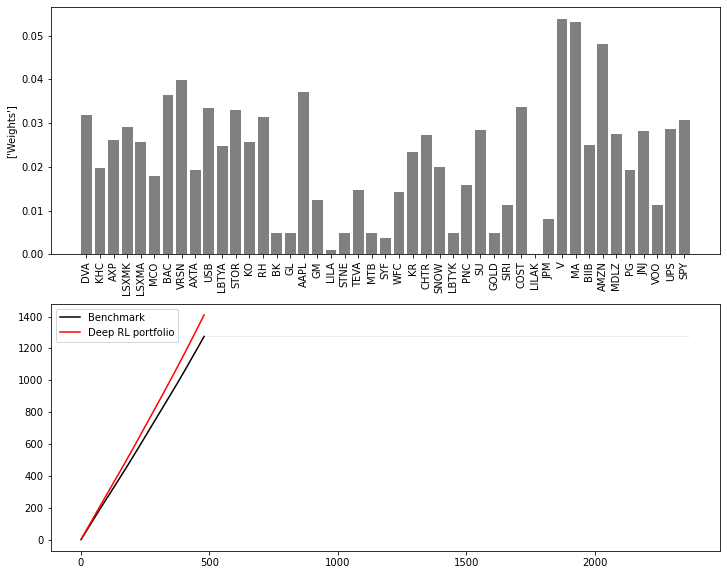

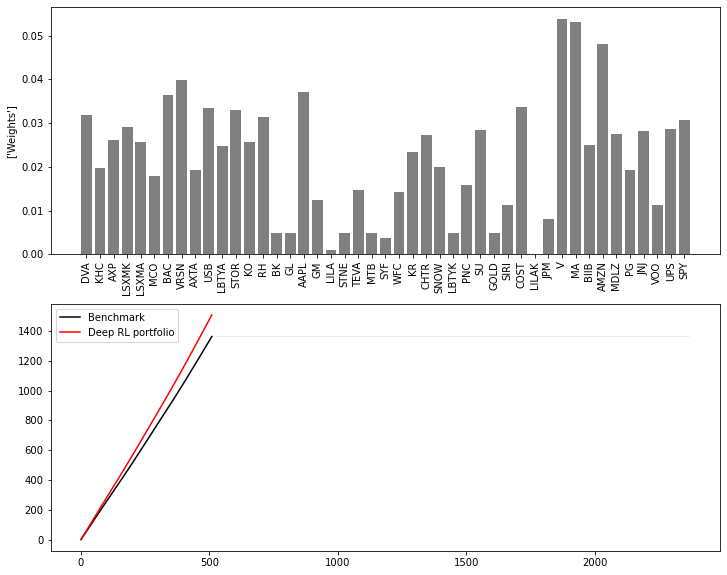

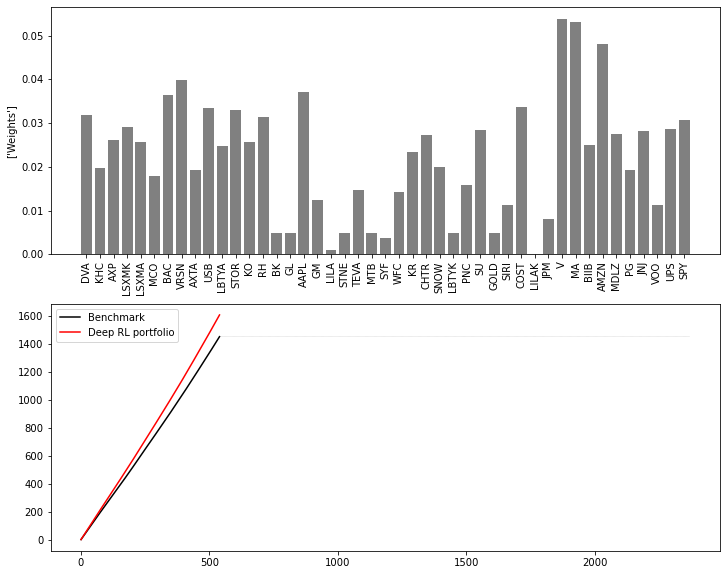

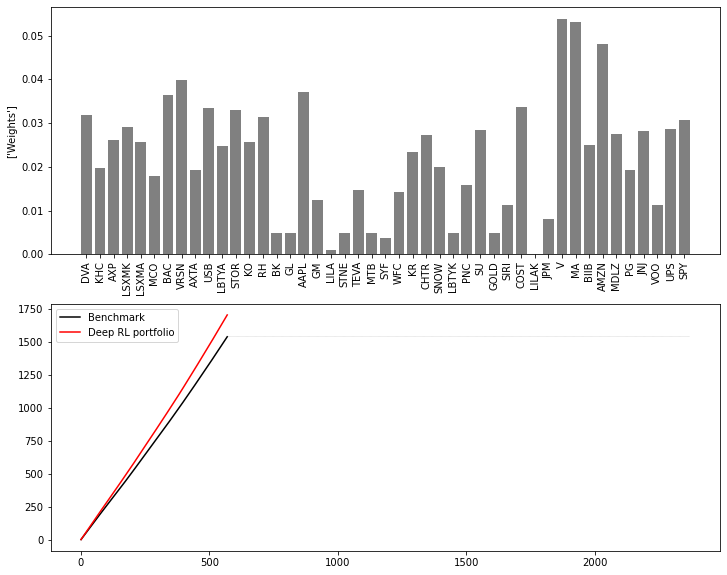

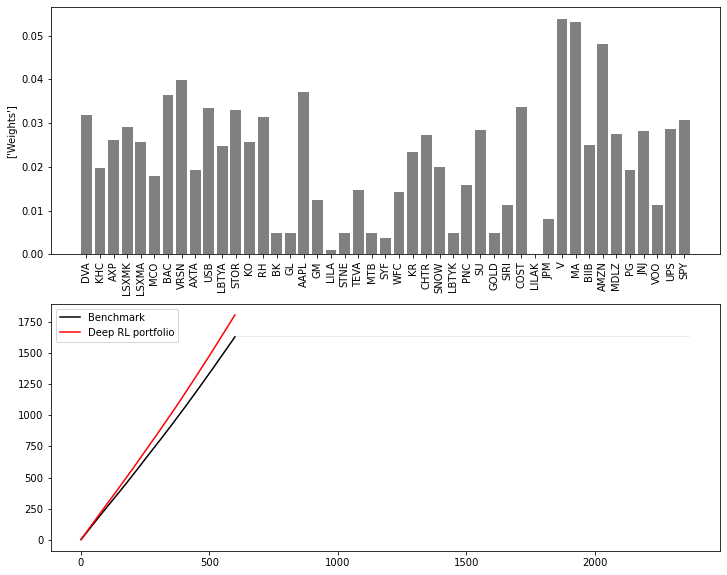

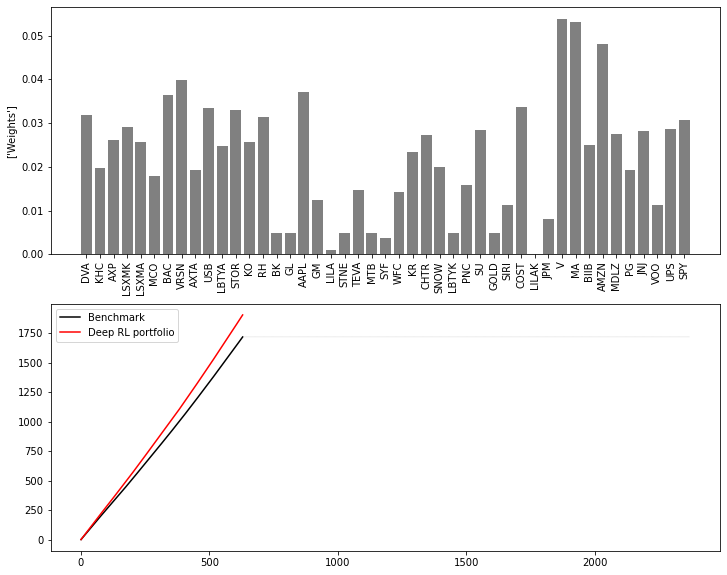

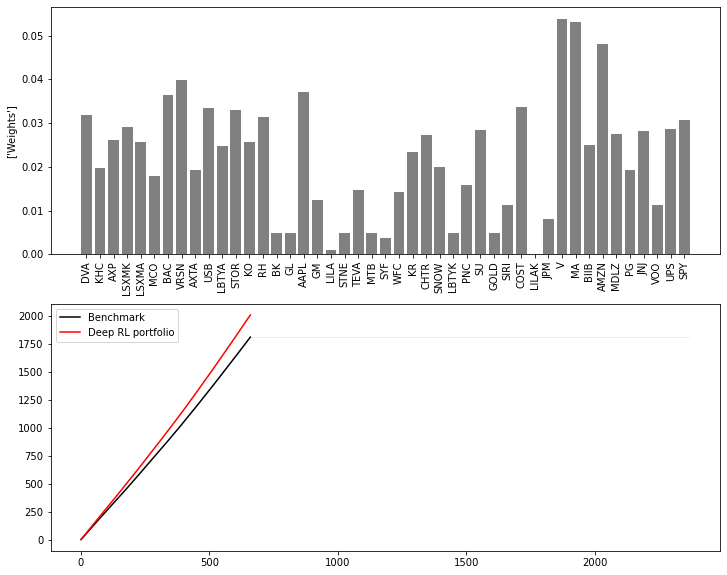

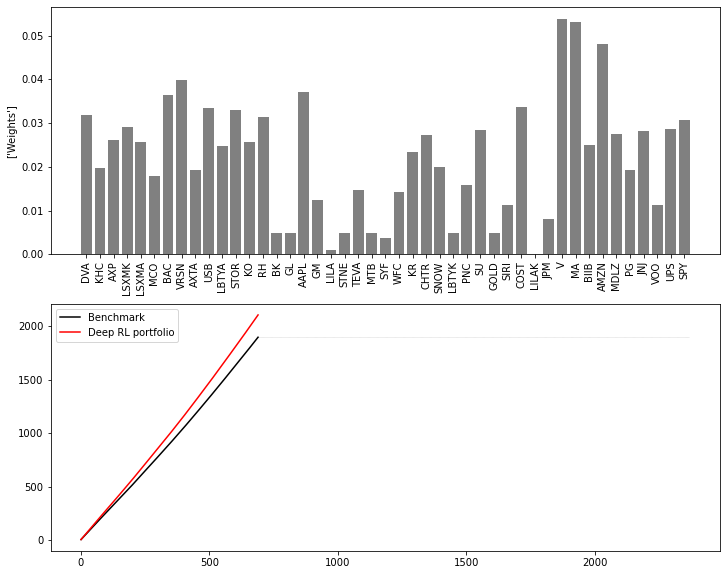

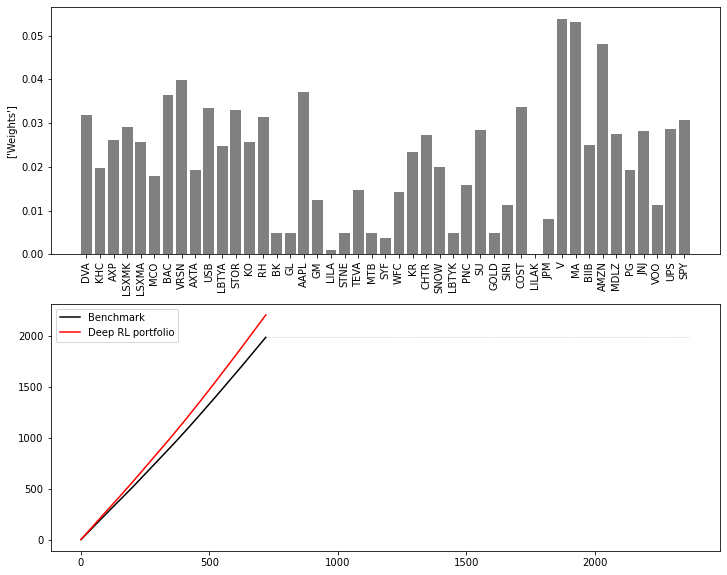

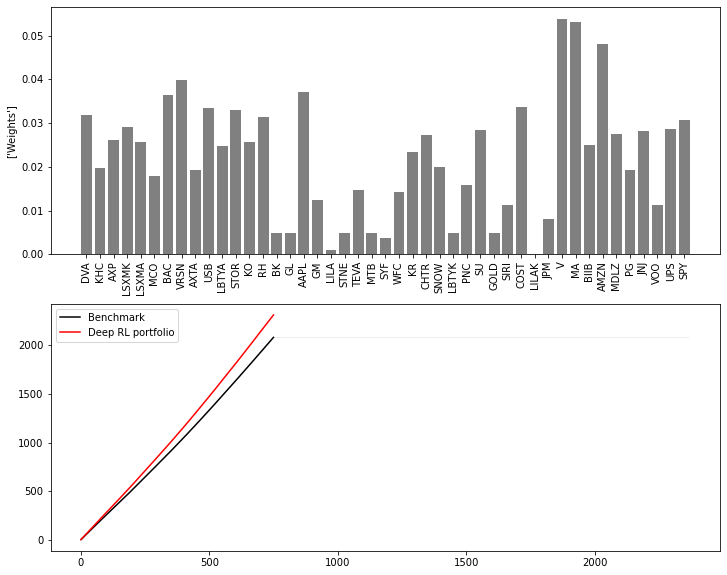

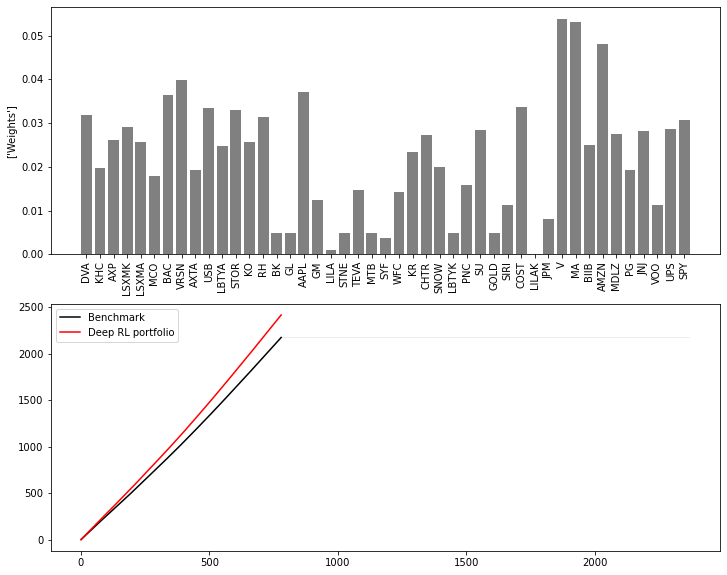

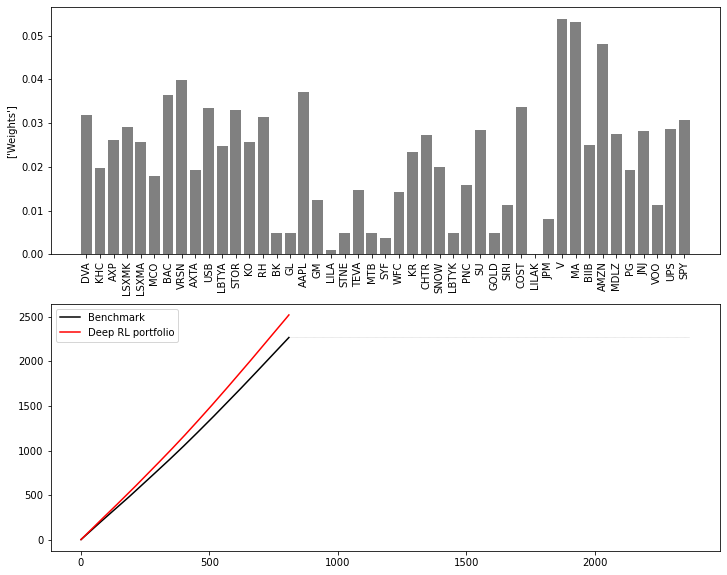

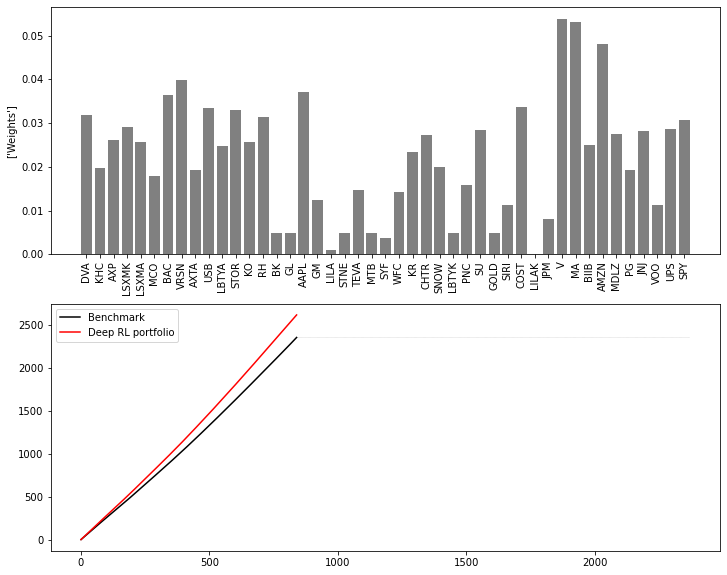

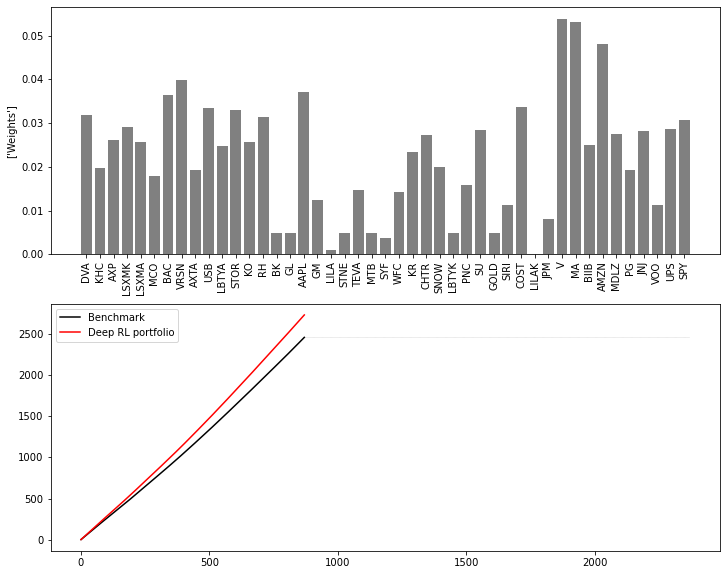

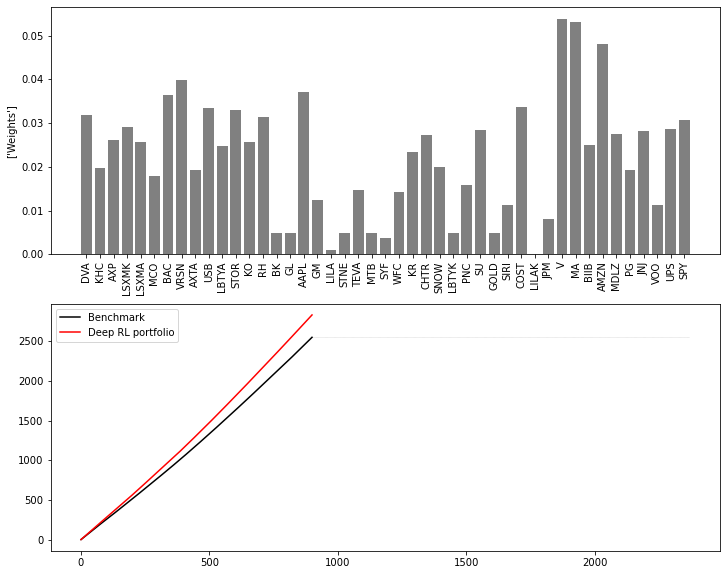

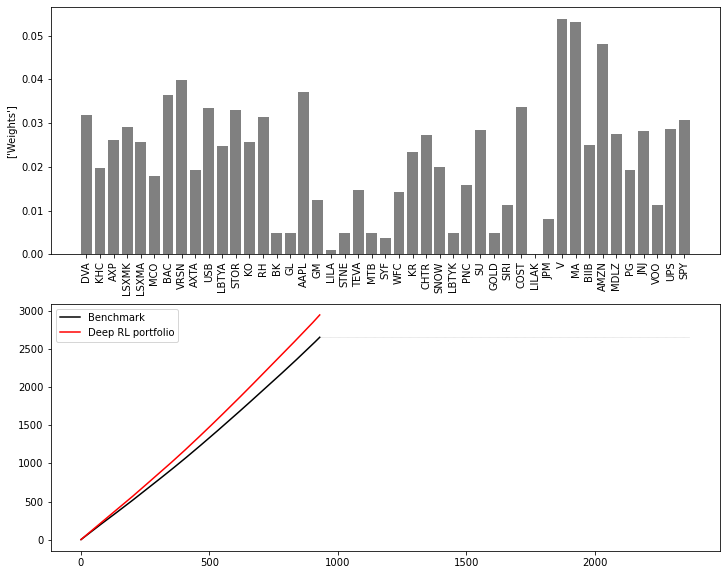

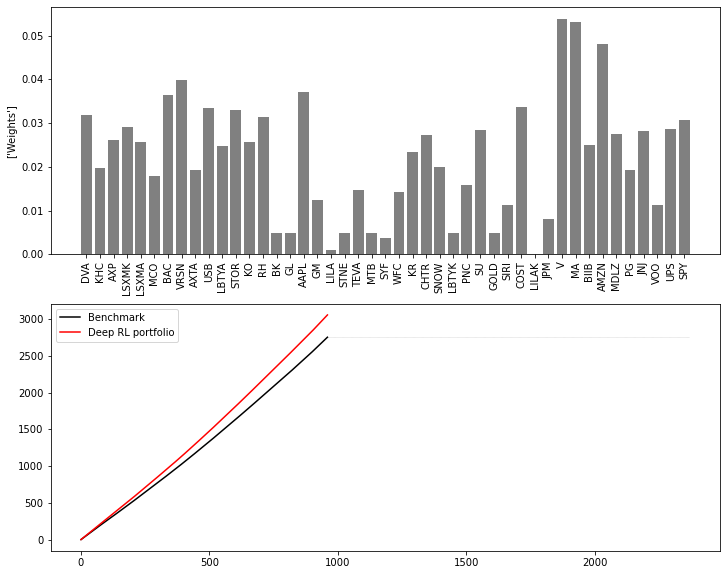

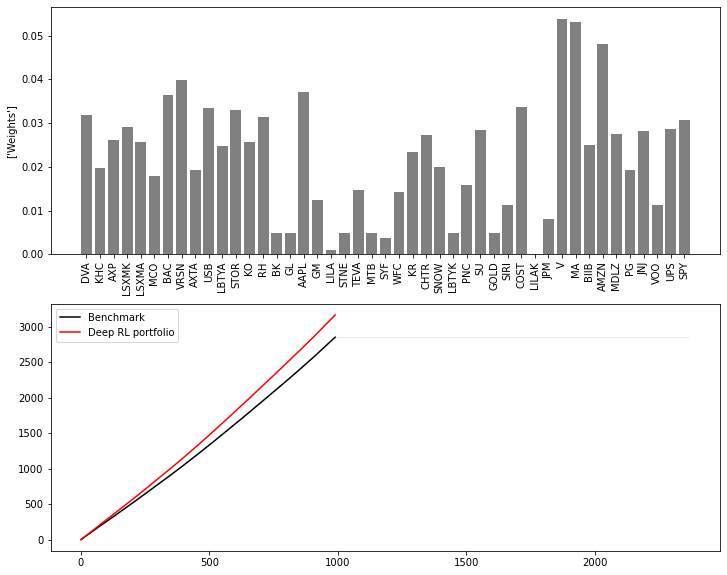

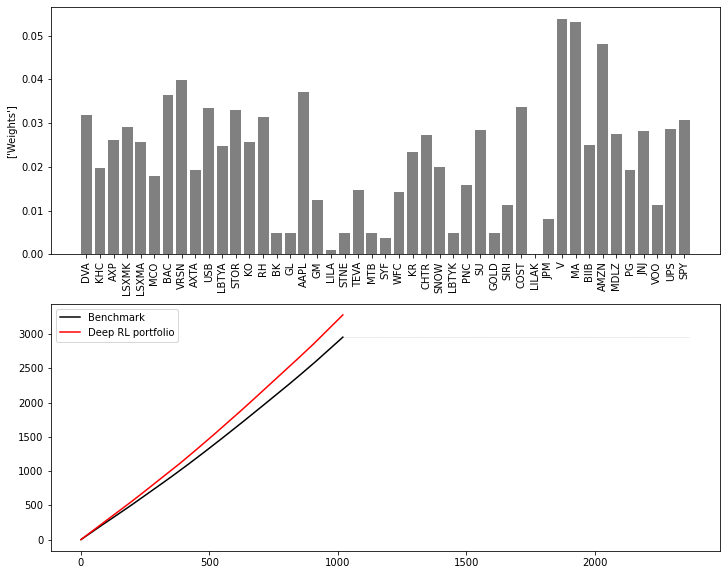

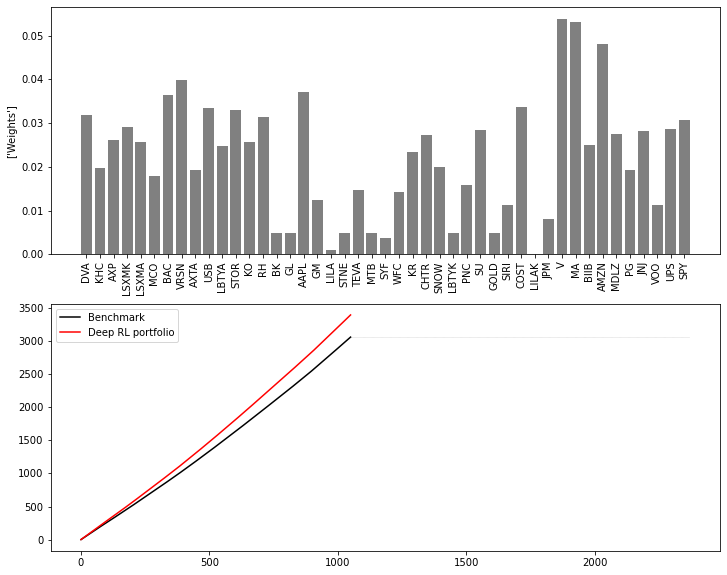

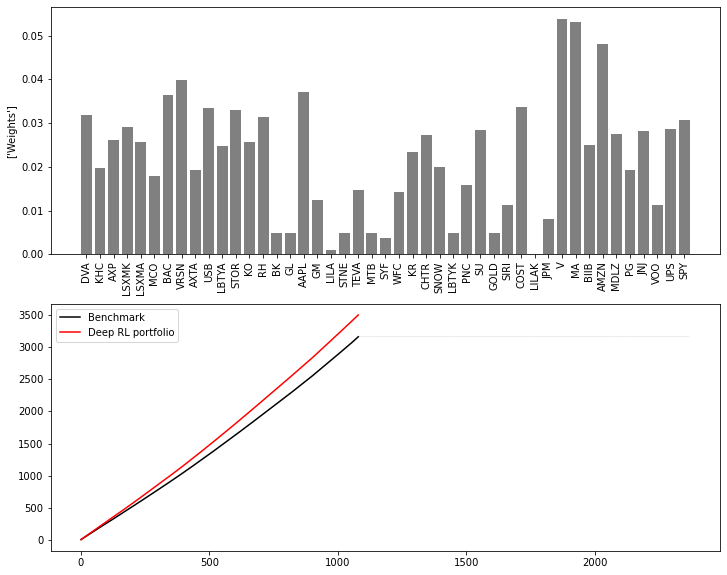

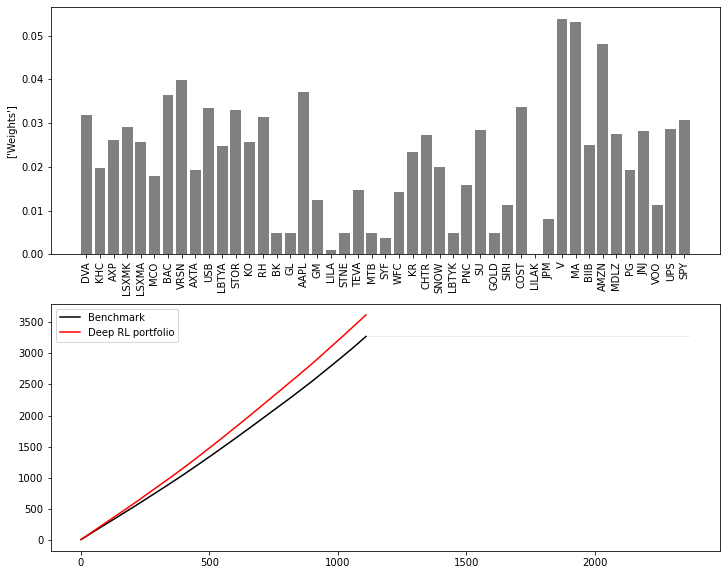

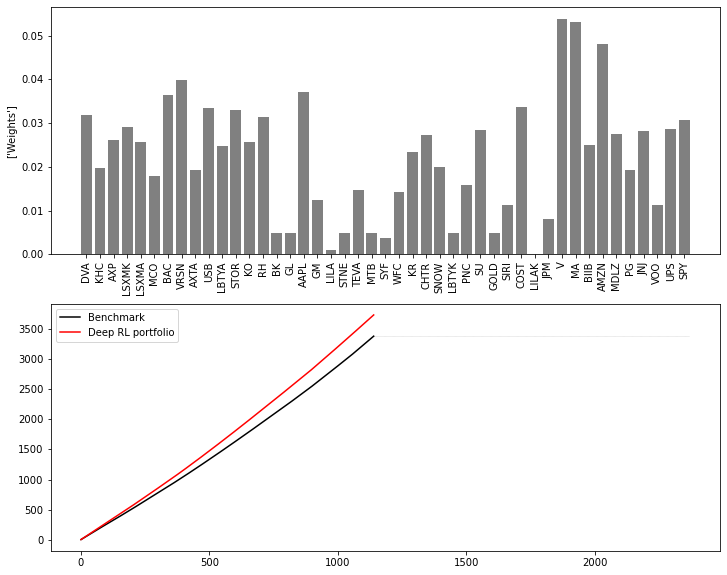

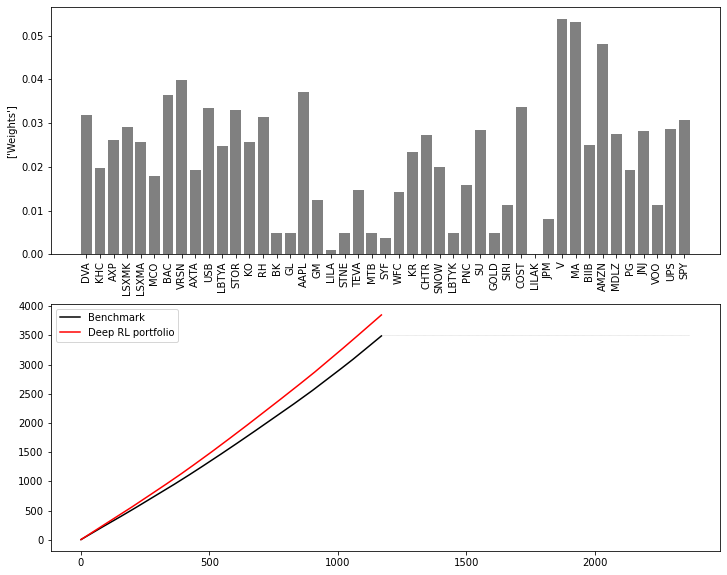

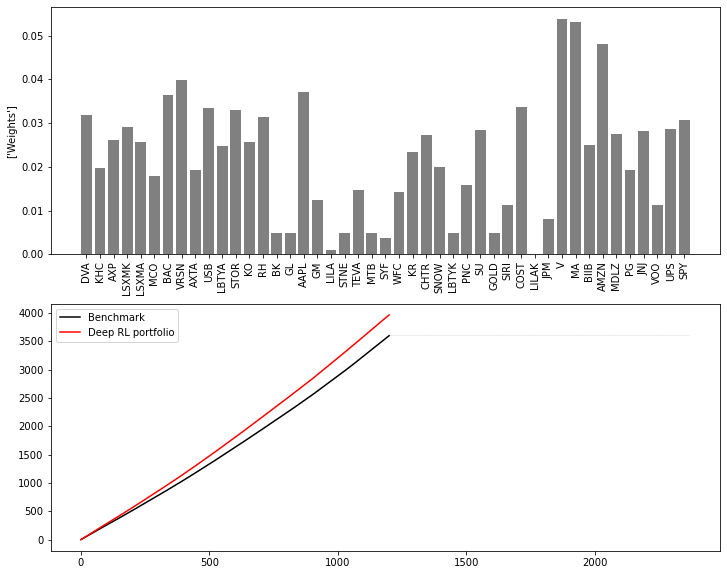

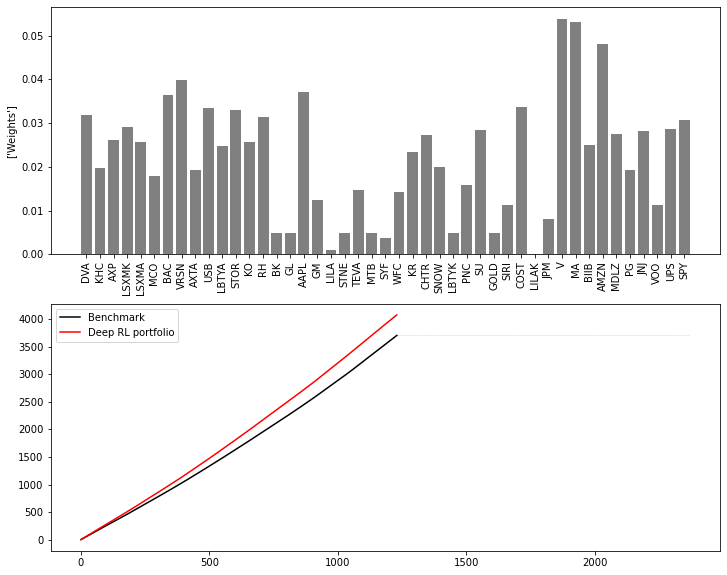

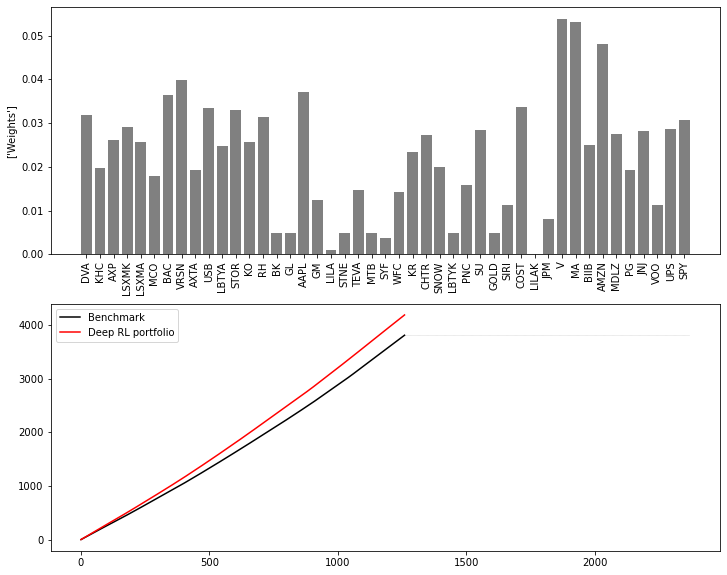

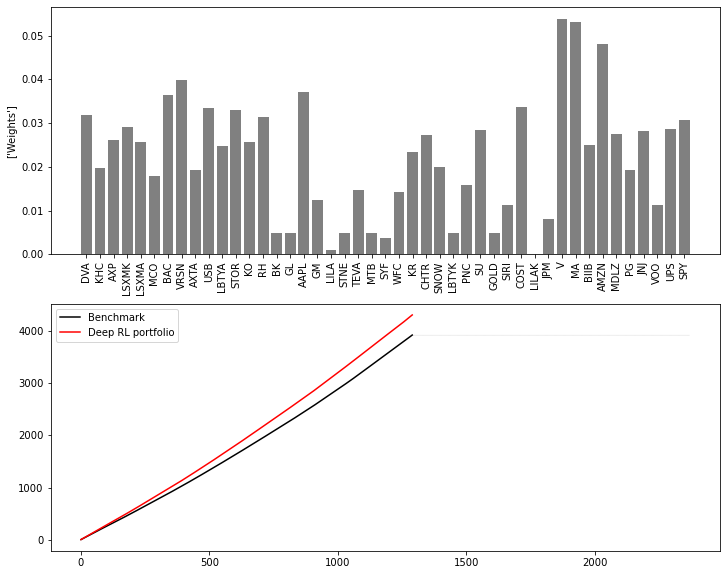

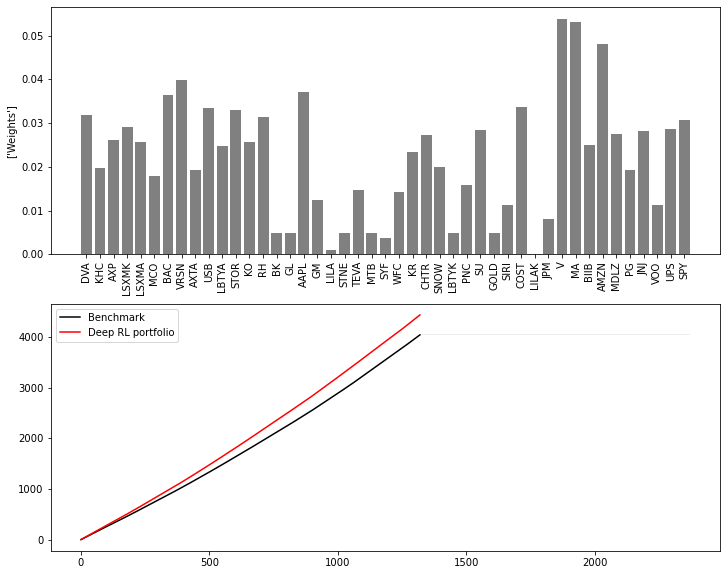

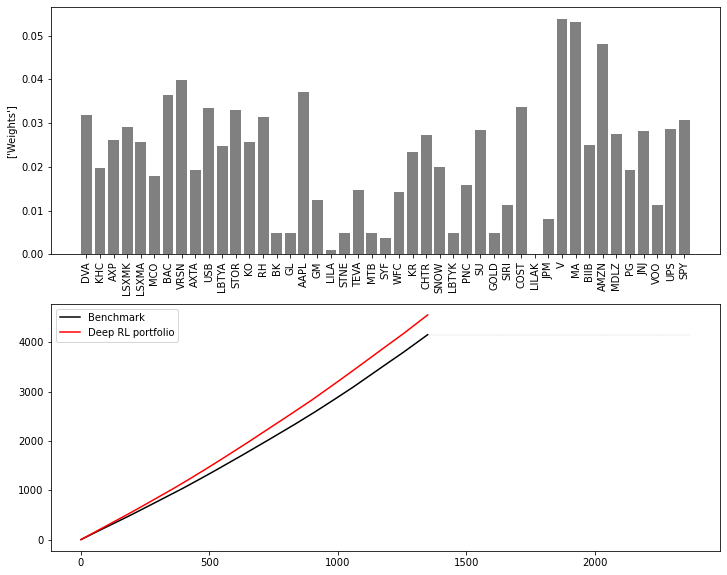

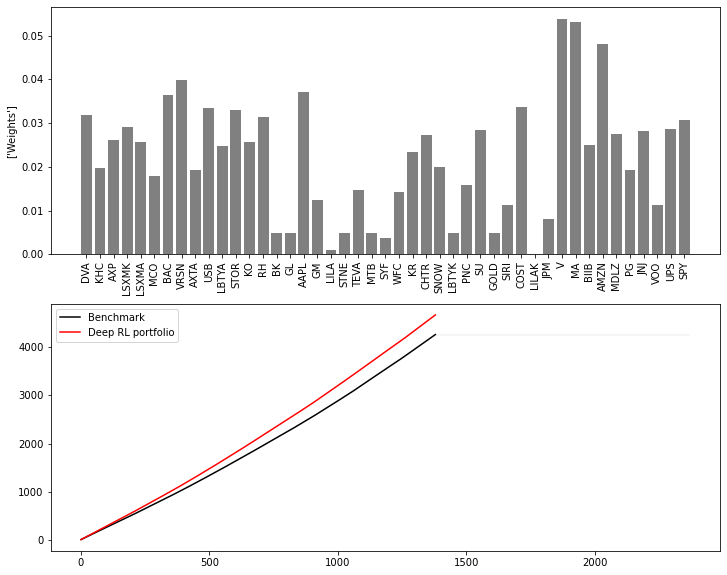

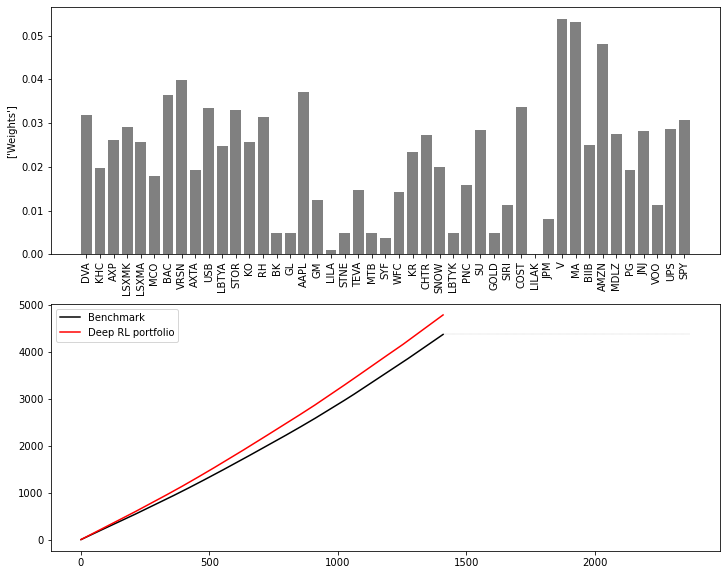

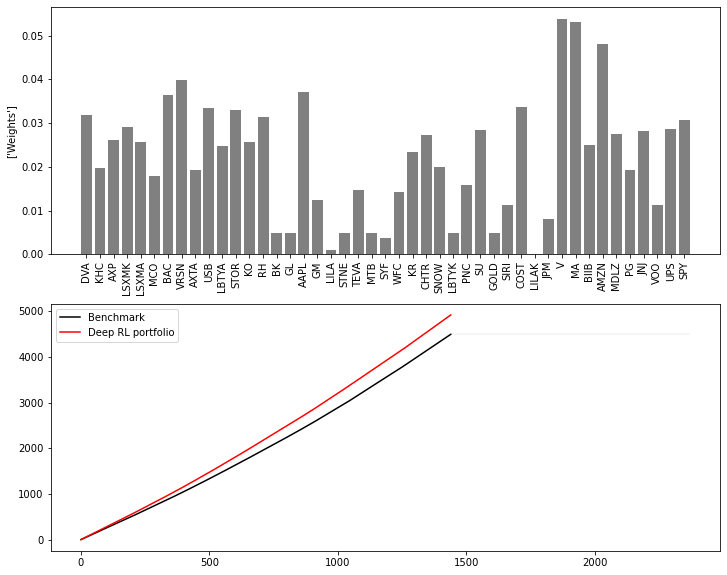

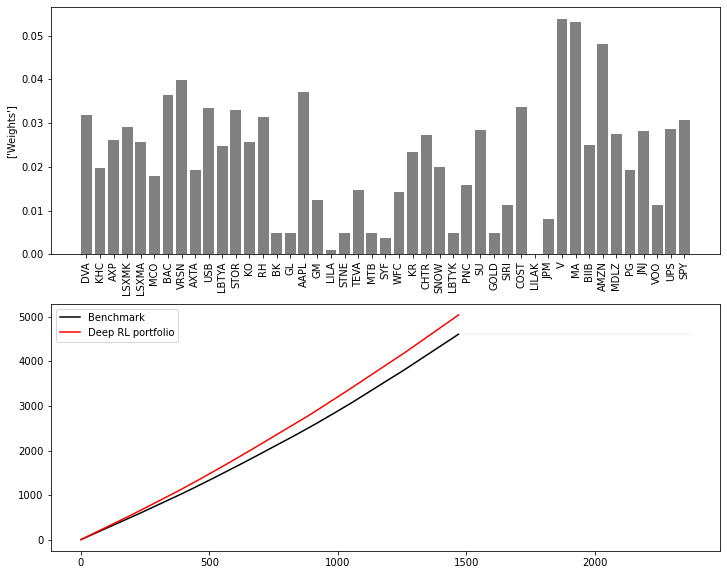

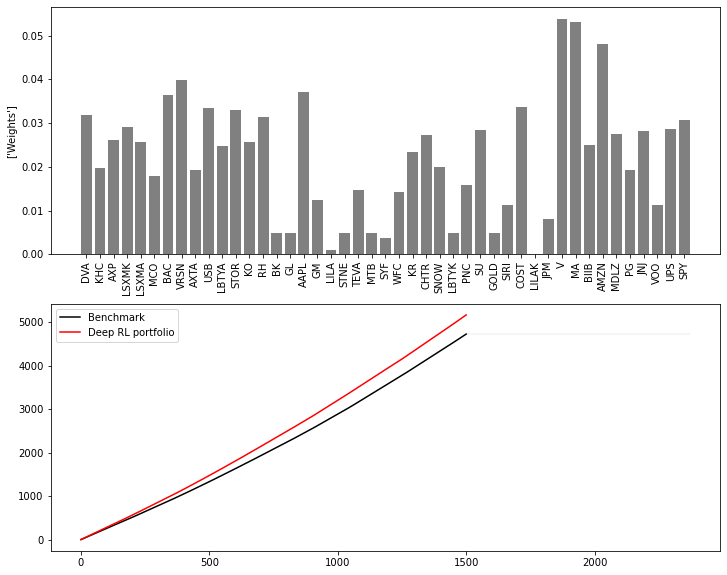

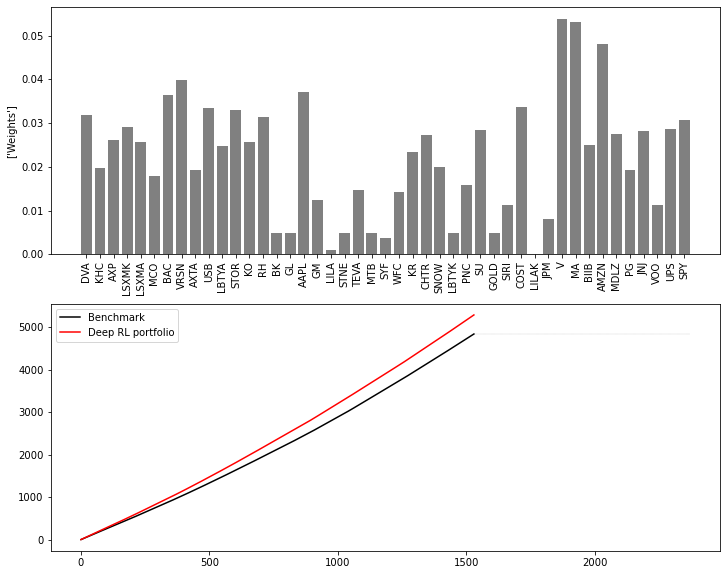

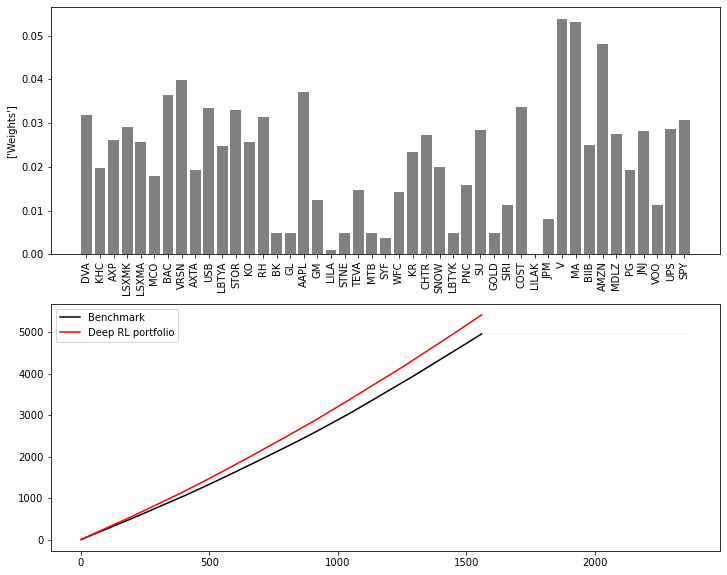

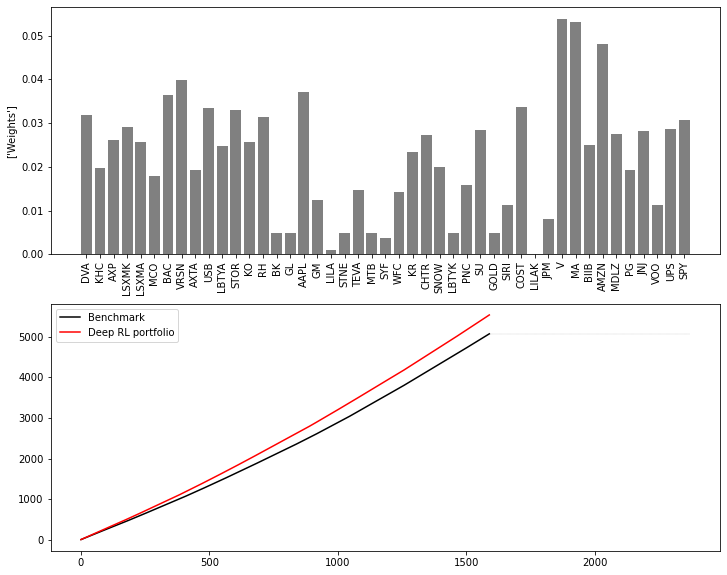

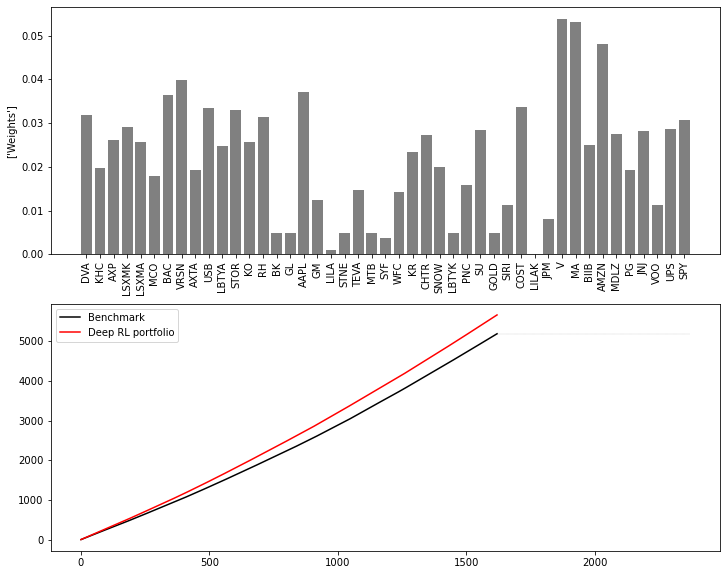

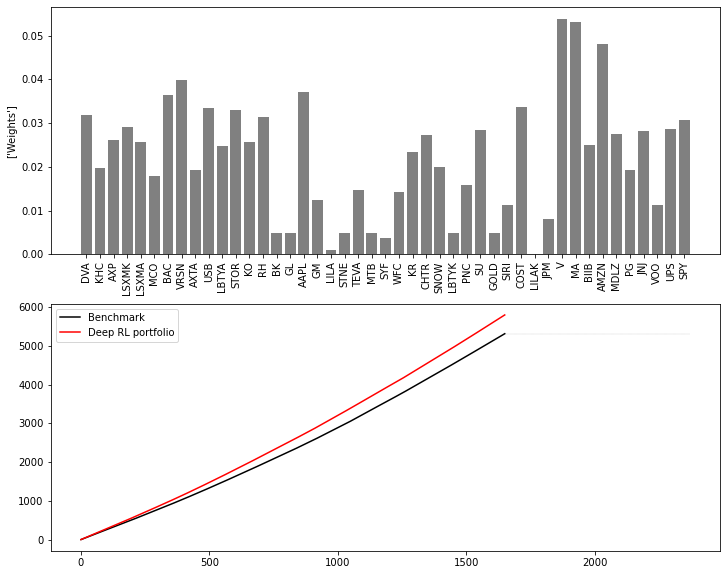

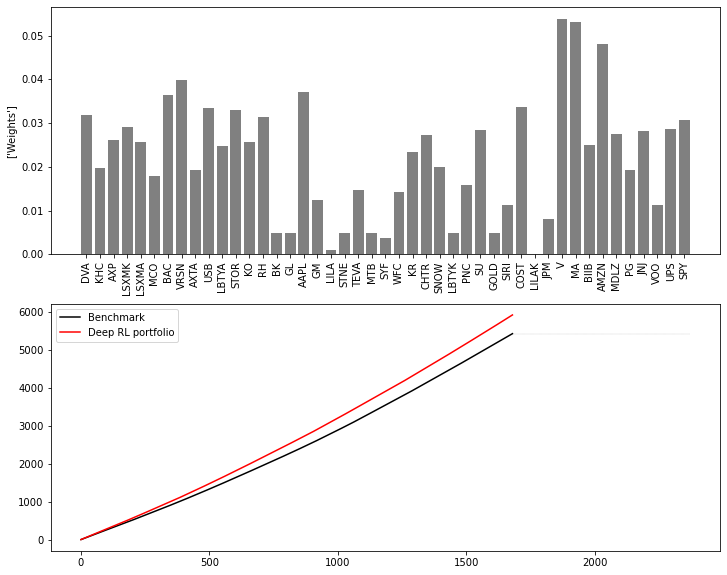

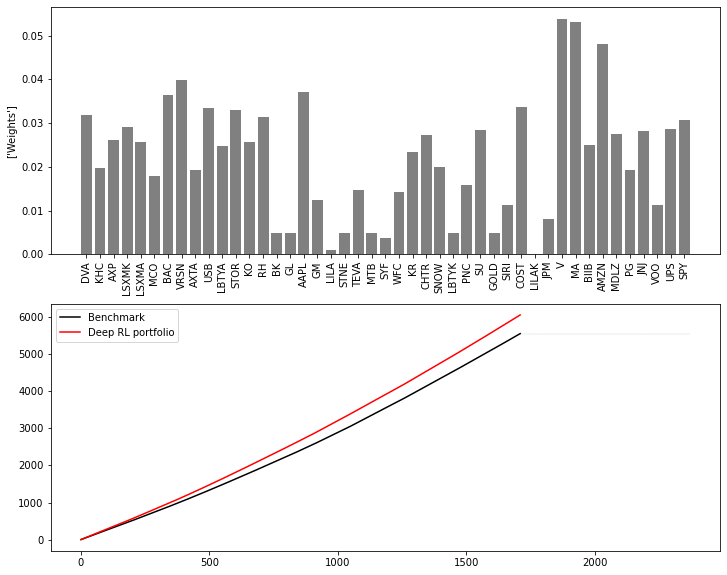

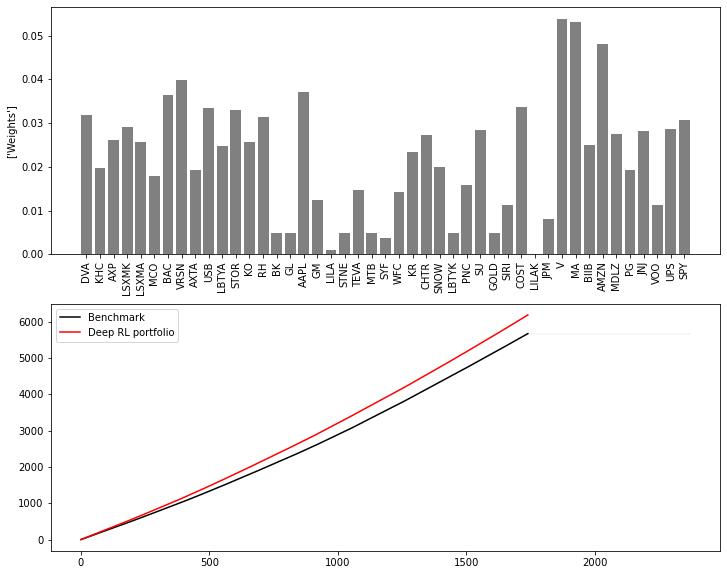

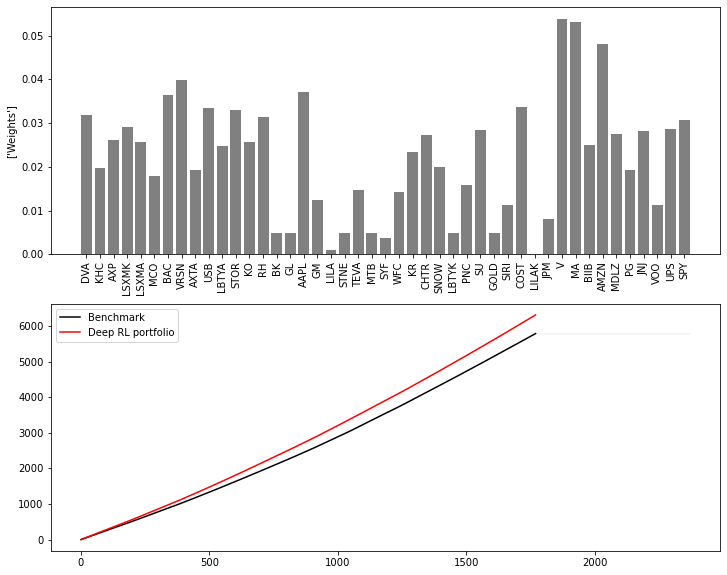

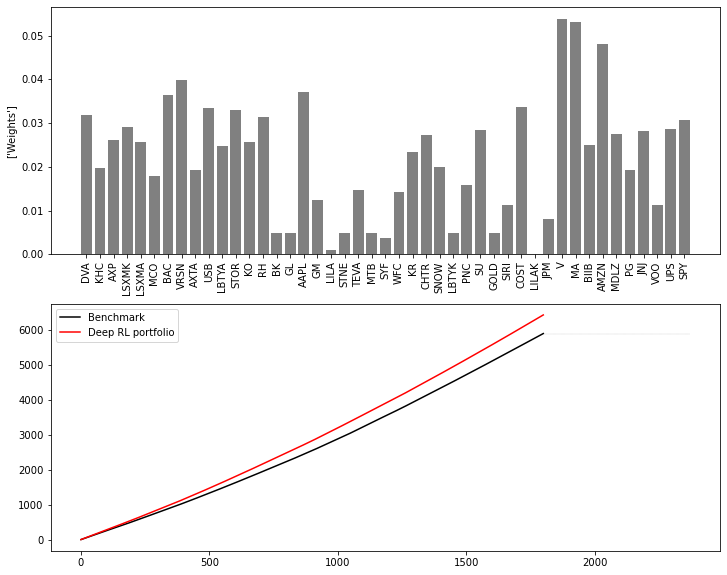

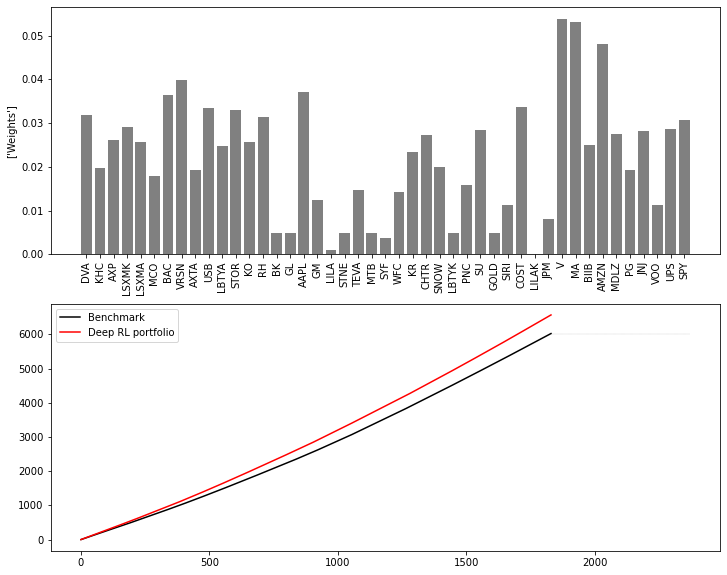

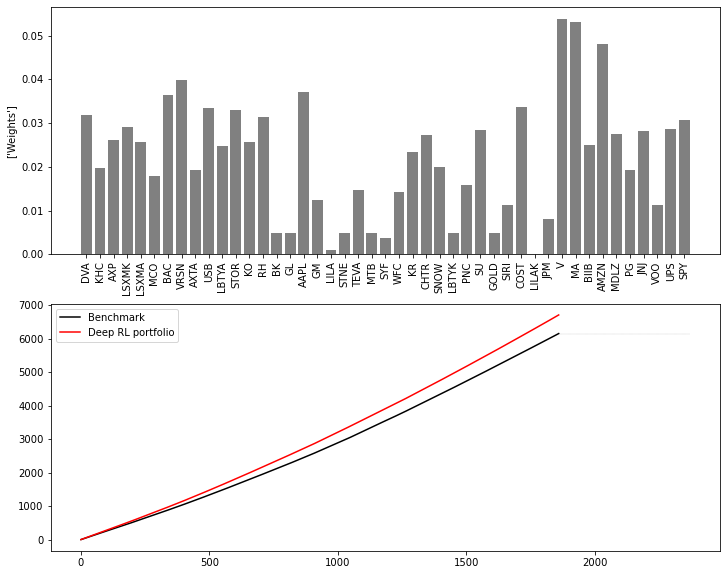

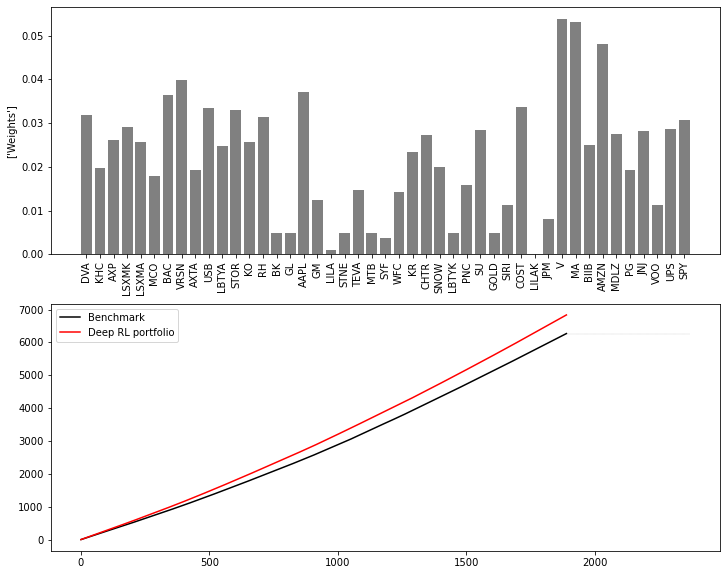

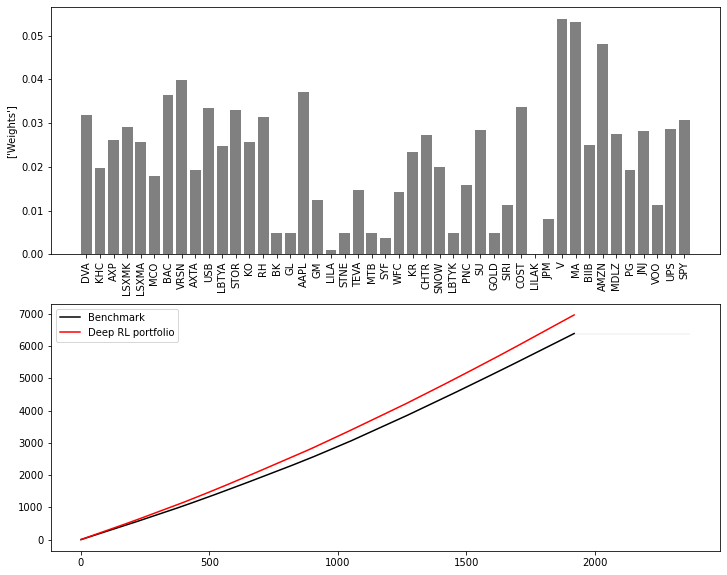

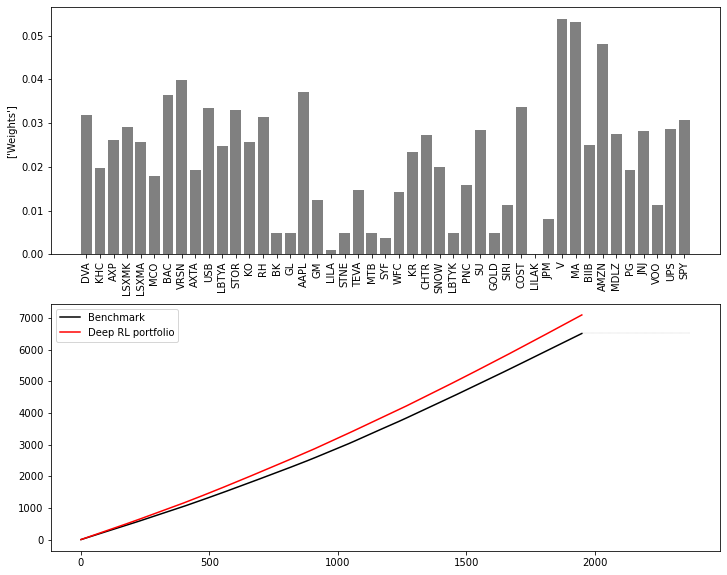

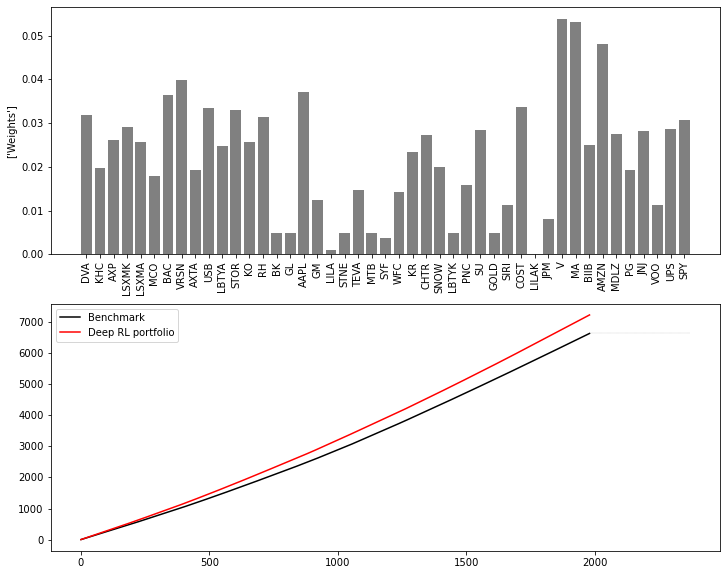

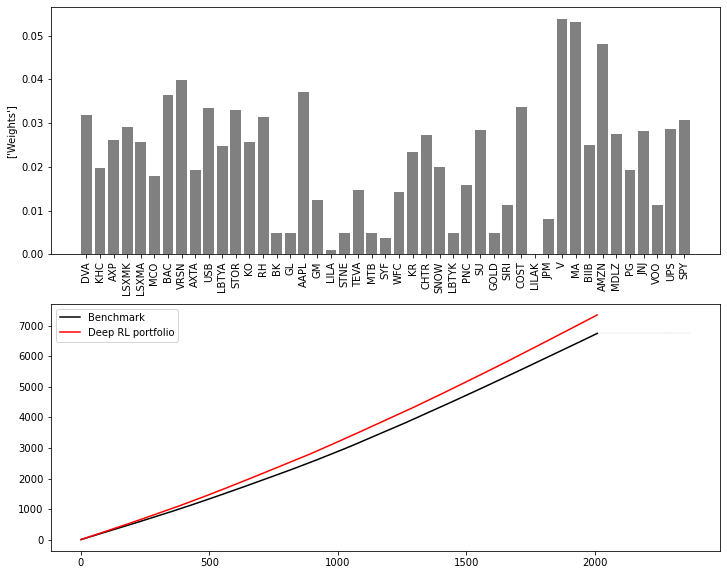

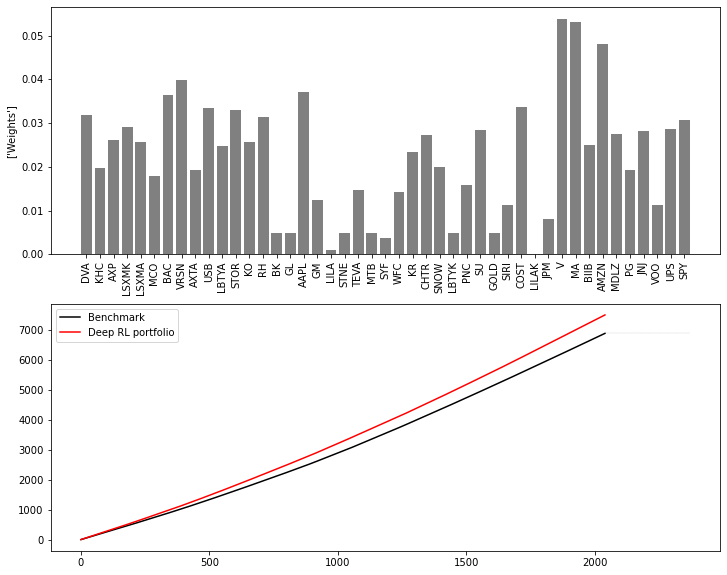

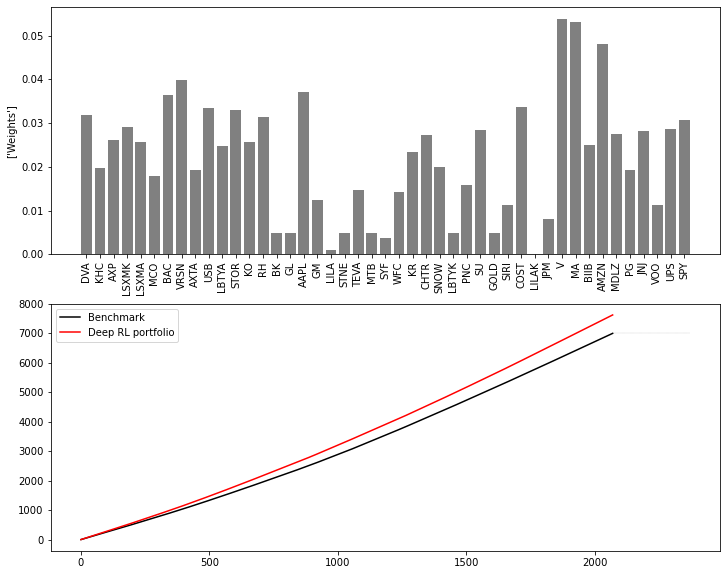

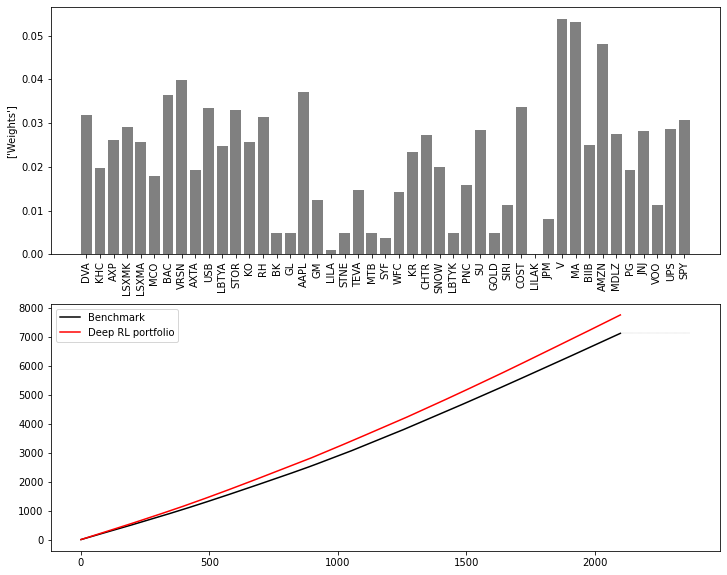

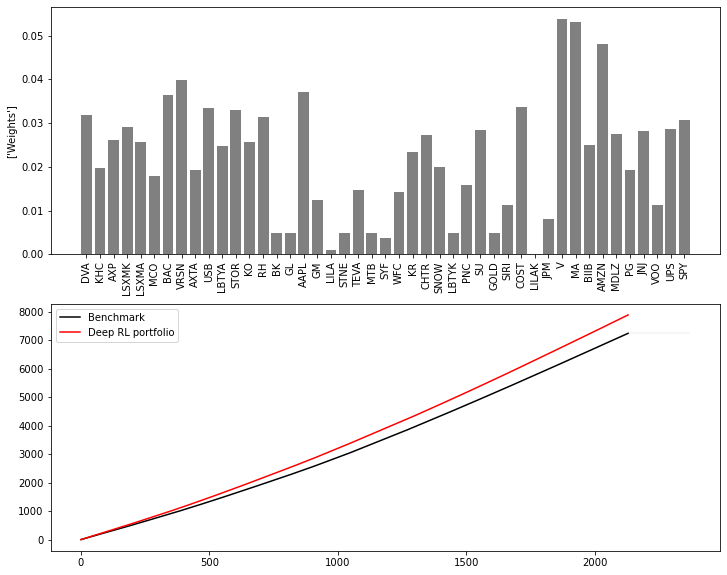

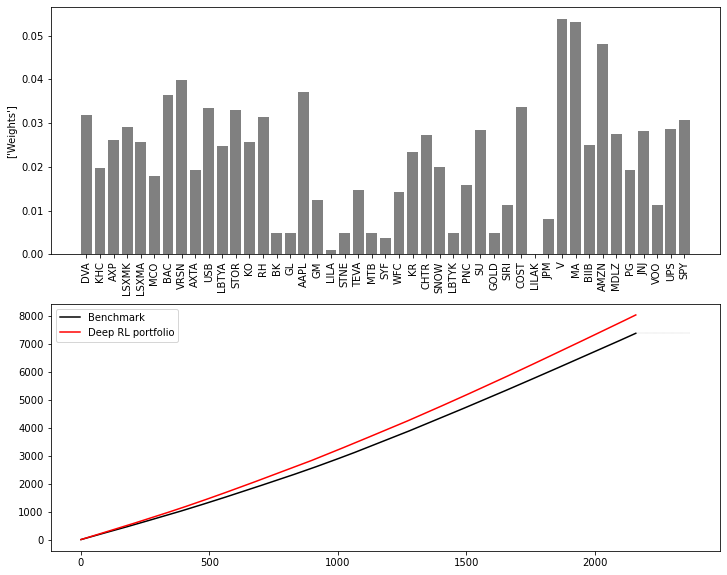

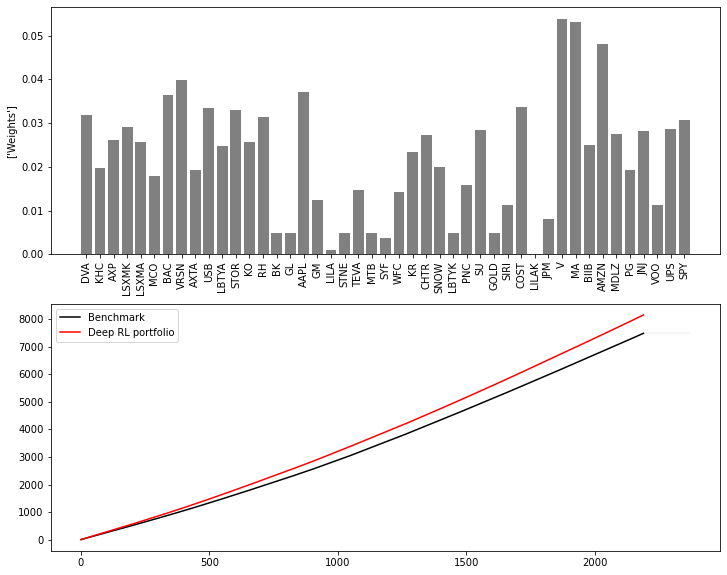

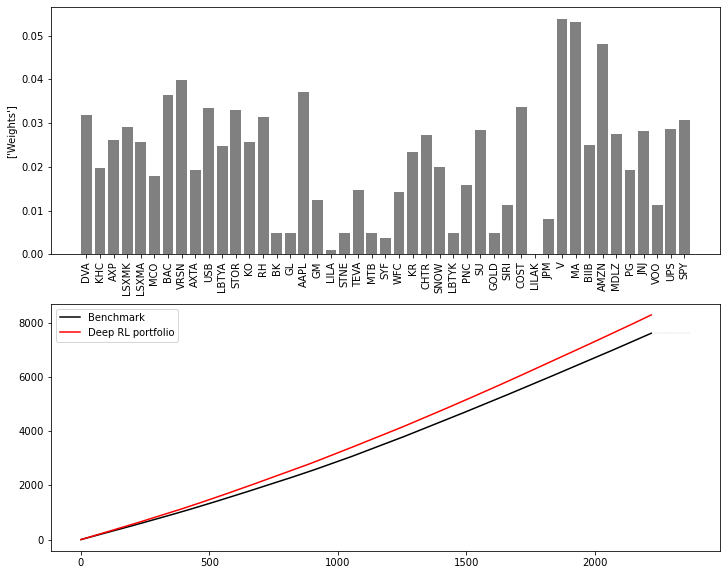

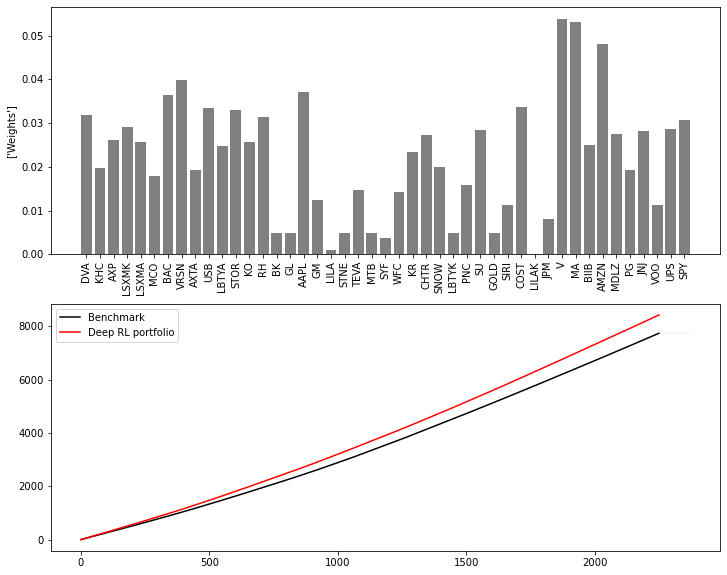

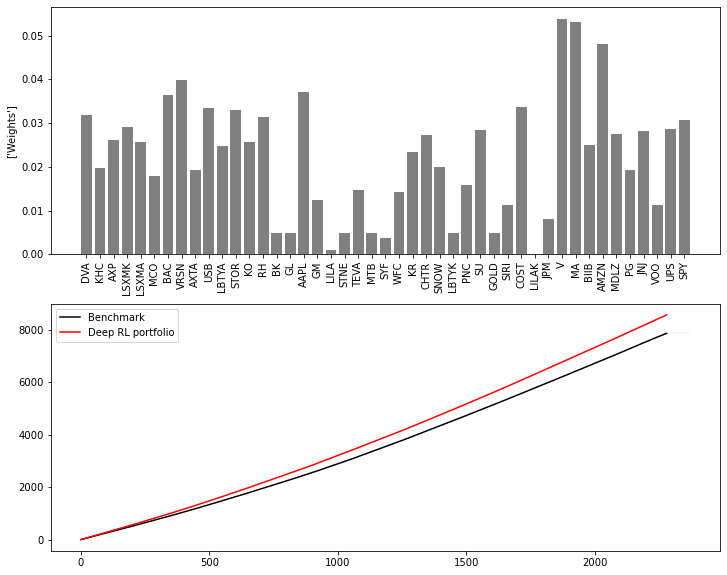

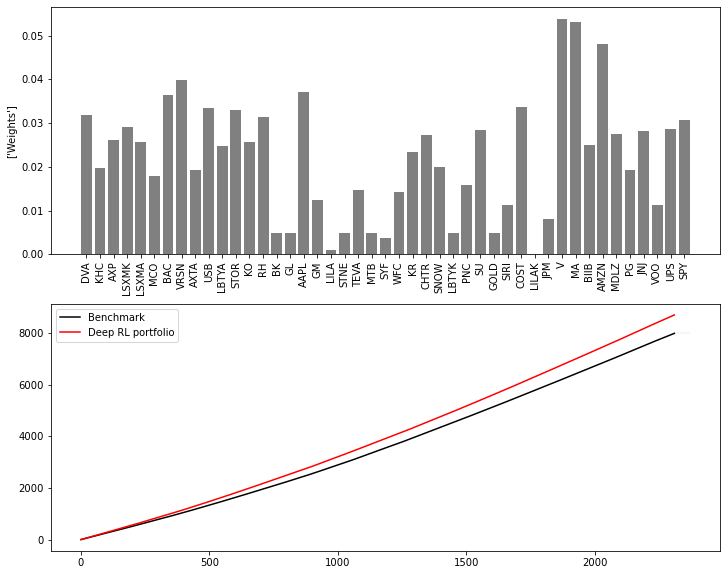

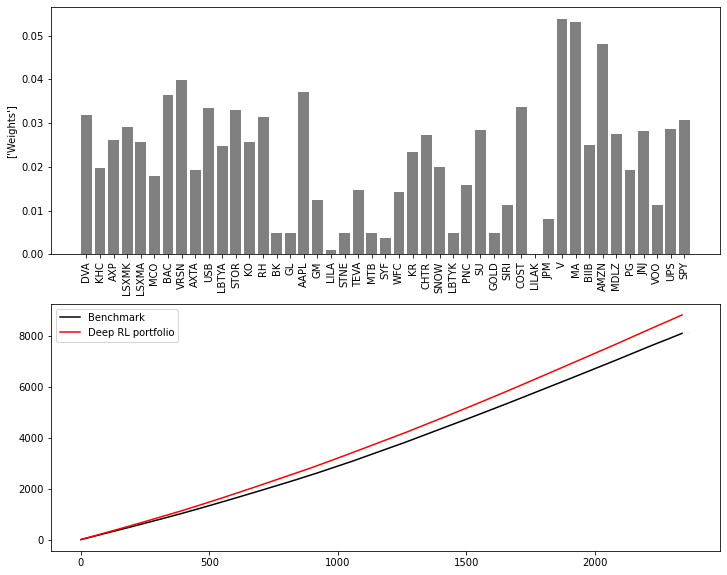

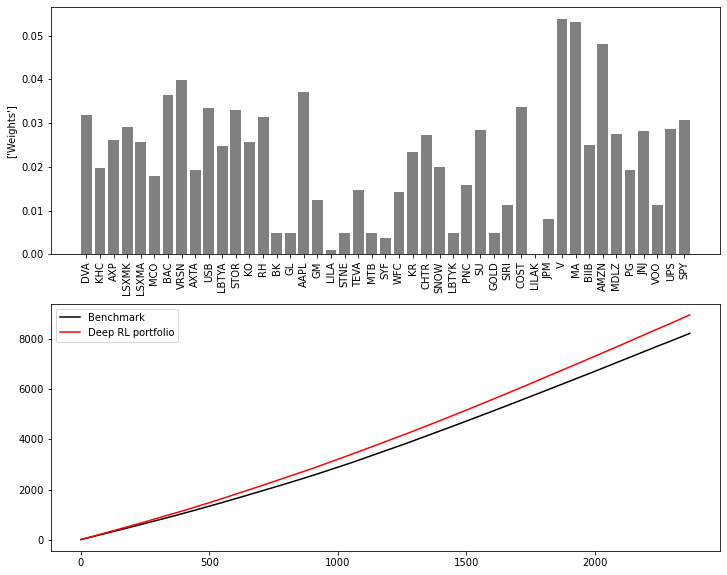

In [17]:
plot_results(result_equal, 
             result_rl, 
             actions_rl, 
             N_ASSETS,
             panel_data.columns, 
             'Deep RL portfolio', './images_test1/rl/', 'series')

In [18]:
# change elu to lstm/softmax
# change linear Dense layer to tanh or sigmoid
# change reward function to predicted stock prices or predicted SR

# END